### K-Sil

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from joblib import Parallel, delayed

class KSil:
    def __init__(self,
                 n_clusters=3,
                 init='random',
                 max_iter=100,
                 random_state=0,
                 init_temperature=1.0,
                 learning_rate=0.2,
                 tol=1e-4,
                 n_init=1, n_jobs=1):

        # Parameters
        self.n_clusters = int(n_clusters)     # Number of clusters
        self.init = init                      # Initialization method
        self.max_iter = int(max_iter)         # Maximum number of iterations
        self.init_temperature = float(init_temperature) # Initial temperature
        self.random_state = int(random_state) # Random seed
        self.learning_rate = learning_rate    # Learning rate for temperature
        self.tol = float(tol)                 # Centroid convergence tolerance

        # For multiple initializations:
        self.n_init = n_init                  # Number of initializations
        self.n_jobs = n_jobs                  # Number of cores

        # n_clusters check
        if self.n_clusters < 2:
           raise ValueError(f"n_clusters ({self.n_clusters}) must be > 1.")
        # init check
        if isinstance(self.init, str) and self.init not in ('random', 'k-means++'):
           raise ValueError(f"init ({self.init}) must be 'random' or 'k-means++'.")
        # n_init check
        if self.n_init < 1:
           raise ValueError(f"n_init ({self.n_init}) must be > 0.")

        # Attributes
        self.labels_ = None          # Cluster labels (converged partition)
        self.cluster_centers_ = None # Cluster centers (converged partition)
        self.n_iter_ = None          # Number of iterations (until convergence)
        self.sil_ = None             # silhouette (centroid-approximated) at converged partition

        # history attributes
        self.centers_history_ = None # Centroids across iterations
        self.labels_history_ = None  # Assignments across iterations
        self.sil_history_ = None     # Silhouette proxy across iterations
        self.weights_history_ = None # Weights across iterations

    def _initialization(self, X, n_clusters):
        X = np.asarray(X)
        if X.shape[0] < n_clusters:
           raise ValueError(f"n_clusters ({n_clusters}) can not exceed n_samples ({X.shape[0]}).")

        kmeans = KMeans(n_clusters=n_clusters,
                        init=self.init,
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        # Retry if some clusters are empty in the initial assignment
        if np.unique(labels).size < n_clusters:
           max_retries = 10 # 10 retries at max
           base_seed = self.random_state
           for attempt in range(1, max_retries + 1):
               seed = base_seed + attempt
               km = KMeans(n_clusters=n_clusters,
                           init=self.init,
                           random_state=seed,
                           n_init=1,
                           max_iter=1).fit(X)
               centers = km.cluster_centers_
               labels = km.labels_
               if np.unique(labels).size == n_clusters:
                  break
           else:
               raise ValueError(
                     f"KMeans (1-iter) initialization produced empty clusters after {max_retries} retries. "
                     f"Try a different random_state, or init='k-means++'.")
        return centers, labels

    def _fit_once(self, X, n_clusters, previous_centers, w):
        X = np.asarray(X)
        w = np.asarray(w)
        km = KMeans(
             n_clusters=n_clusters,
             init=previous_centers,
             n_init=1,
             max_iter=1,
             random_state=self.random_state)
        km.fit(X, sample_weight=w)

        centers = km.cluster_centers_
        labels = km.labels_
        return centers, labels

    @staticmethod
    def sil_scores(X, labels, centers):
        X = np.asarray(X, dtype=float)
        labels = np.asarray(labels, dtype=int)
        centers = np.asarray(centers, dtype=float)

        if len(X) == 0:
           raise ValueError("X is empty. Cannot compute silhouette scores.")

        n = X.shape[0]

        # Squared distances to all centroids
        D = euclidean_distances(X, centers, squared=True)

        # Distance to own centroid (a: intra cluster distance proxy)
        D_diag = D[np.arange(n), labels]  # a^2
        a_vals = np.sqrt(D_diag)  # a

        # Nearest other centroid distance (b: inter cluster distance)
        D_others = D.copy()
        D_others[np.arange(n), labels] = np.inf
        b_sq = D_others.min(axis=1)  # b^2
        b_vals = np.sqrt(b_sq)  # b

        # Silhouette surrogate (b-a)/[max{a,b}+epsilon]
        max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-12)
        s_vals = (b_vals - a_vals) / max_ab

        return s_vals, a_vals, b_vals

    @staticmethod
    def micro_sil(s_vals):
        s_vals = np.asarray(s_vals, dtype=float)
        if s_vals.size == 0:
           return 0.0
        return float(s_vals.mean())

    @staticmethod
    def macro_sil(s_vals, labels):
        s_vals = np.asarray(s_vals, dtype=float)
        labels = np.asarray(labels, dtype=int)

        if s_vals.size == 0 or labels.size == 0:
           return 0.0

        uniq, inv = np.unique(labels, return_inverse=True)
        if uniq.size == 0:
           return 0.0
        sum_per_cluster = np.bincount(inv, weights=s_vals)
        cnt_per_cluster = np.bincount(inv)

        valid = cnt_per_cluster > 0
        if not np.any(valid):
           return 0.0
        cluster_means = sum_per_cluster[valid] / cnt_per_cluster[valid]
        return float(cluster_means.mean())

    def _weights(self, s_vals, temperature):
        s_vals = np.asarray(s_vals, dtype=float)
        weights = np.exp(s_vals * temperature)
        return weights

    def _KSil(self, X, n_clusters, max_iter):

        # Initialize centroids
        centers, labels = self._initialization(X, n_clusters)
        tau = self.init_temperature # initial temperature
        prev_score =  None

        centers_history = [centers.copy()]
        labels_history = [labels.copy()]
        sil_history = []
        weights_history = []

        n_iter = 0

        while n_iter < max_iter:

            n_iter += 1

            # Compute point-silhouette scores
            sil_vals, a_vals, b_vals = KSil.sil_scores(X, labels, centers)
            score = KSil.macro_sil(sil_vals, labels)

            micro_sil = KSil.micro_sil(sil_vals)
            sil_history.append(micro_sil)

            # Update temperature
            if prev_score is not None:
               r = (score - prev_score) / max(1 - prev_score, 1e-12)

               r = float(np.clip(r, -1.0, 1.0))

               # data-driven bounds to avoid softmax saturation
               counts = np.bincount(labels, minlength=n_clusters)
               m_max = int(max(counts.max(), 2))
               L     = float(np.sqrt(2.0 * np.log(m_max)))
               z_max = (m_max - 1) / m_max
               tau_min, tau_max = 1e-12, L / max(z_max, 1e-8)

               # multiplicative update (no logs needed)
               eta = self.learning_rate # default: 0.2 (small stable learning rate)

               # Update temperature based on the rate of change of the silhouette objective
               tau = float(np.clip(tau * np.exp(eta * r), tau_min, tau_max))

            # store for next iteration’s drift calc
            prev_score = score

            # Retain previous centroids for convergence checking
            previous_centers = centers.copy()

            # Compute weights based on silhouette scores
            weights = self._weights(sil_vals, tau)

            weights_history.append(weights.copy())

            # Update centroids and assignments
            centers, labels = self._fit_once(X, n_clusters, previous_centers, weights)

            centers_history.append(centers.copy())
            labels_history.append(labels.copy())

            avg_move = np.linalg.norm(centers - previous_centers, axis=1).mean()

            # Centroid stability
            if avg_move < self.tol:
               break

        return centers, labels, n_iter, sil_history, centers_history, labels_history, weights_history

    def fit(self, X):
        """
        Run KSil on X and store the converged partition.
        X: array-like, shape (n_samples, n_features)
        """
        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)

        if self.n_init == 1:
           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = self._KSil(X_arr, self.n_clusters, self.max_iter)
        else:
           base_seed = self.random_state
           seeds = [int(base_seed) + i for i in range(self.n_init)]

           # Helper: directly call _KSil with a seed
           def _run_one(seed):
               self.random_state = seed
               return self._KSil(X_arr, self.n_clusters, self.max_iter)

           if self.n_jobs in (None, 1):
              results = [_run_one(seed) for seed in seeds]
           else:
              results = Parallel(n_jobs=self.n_jobs)(delayed(_run_one)(seed) for seed in seeds)

           # Pick best run by final silhouette
           best_idx = None
           best_sil = -np.inf

           for i, res in enumerate(results):
               (_, _, _, sil_history_i,
               _, _, _) = res
               if sil_history_i:
                  final_sil_i = sil_history_i[-1]
               else:
                  final_sil_i = -np.inf
               if final_sil_i > best_sil:
                   best_sil = final_sil_i
                   best_idx = i

           (centers,
           labels,
           n_iter,
           sil_history,
           centers_history,
           labels_history,
           weights_history) = results[best_idx]

           self.random_state = base_seed # restore base random_state

        self.cluster_centers_ = centers
        self.labels_ = labels
        self.n_iter_ = n_iter

        self.sil_history_ = sil_history
        self.sil_ = sil_history[-1] if sil_history else None
        self.centers_history_ = centers_history
        self.labels_history_ = labels_history
        self.weights_history_ = weights_history

        return self

    def predict(self, X):
        """
        Assign new points to the nearest learned centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        dist_matrix = euclidean_distances(X_arr, self.cluster_centers_, squared=True)
        labels = np.argmin(dist_matrix, axis=1)
        return labels.astype(int)

    def transform(self, X):
        """
        Return distances of each sample to each centroid.
        """
        if self.cluster_centers_ is None:
           raise ValueError("KSil model is not fitted yet. Call '.fit(...)' first.")

        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        distances = euclidean_distances(X_arr, self.cluster_centers_, squared=False)
        return distances

    def fit_predict(self, X):
        """
        Equivalent to: fit(X); return labels_.
        """
        self.fit(X)
        return self.labels_

    def fit_transform(self, X):
        """
        Equivalent to: fit(X); return transform(X).
        """
        self.fit(X)
        return self.transform(X)

### Instance weights visualization on synthetic data

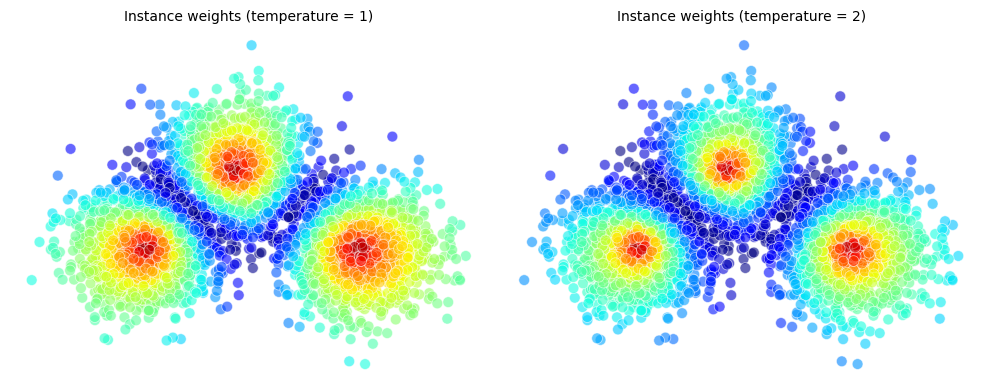

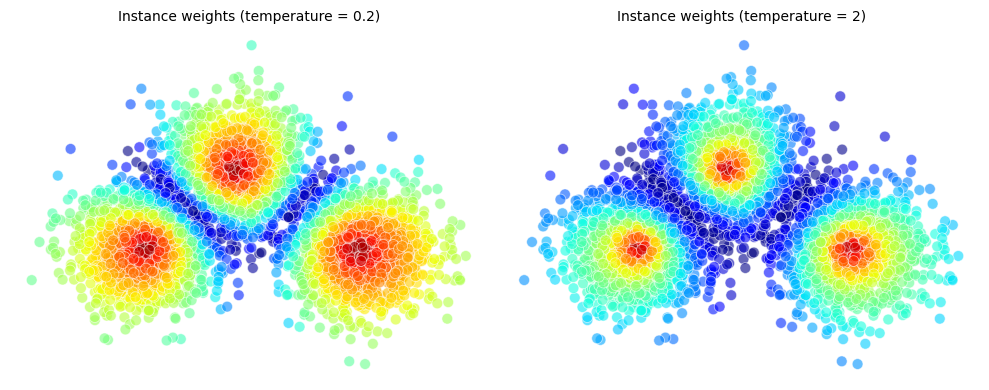

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X, y_true = make_blobs(
    n_samples=4000,
    centers=[[0, 0], [5, 5], [12, 0]],
    cluster_std=2,
    random_state=42
)

n_clusters = 3
base_km = KMeans(
    n_clusters=n_clusters,
    init='random',
    random_state=0
).fit(X)

centers = base_km.cluster_centers_
labels = base_km.labels_

s_vals, a_vals, b_vals = KSil.sil_scores(X, labels, centers)

tau_low = 1
tau_high = 2

w_low = np.exp(s_vals * tau_low)
w_high = np.exp(s_vals * tau_high)

def normalize(v):
    v = np.asarray(v, dtype=float)
    v_min, v_max = v.min(), v.max()
    return (v - v_min) / (v_max - v_min + 1e-12)

w_low_norm = normalize(w_low)
w_high_norm = normalize(w_high)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

titles = [
    f"Instance weights (temperature = {tau_low})",
    f"Instance weights (temperature = {tau_high})"
]
weight_sets = [w_low_norm, w_high_norm]

scatter = None
for ax, w_norm, title in zip(axes, weight_sets, titles):
    scatter = ax.scatter(
        X[:, 0], X[:, 1],
        c=w_norm,
        cmap="jet",
        s=60,
        alpha=0.6,
        linewidth=0.6,
        edgecolor='w'
    )
    ax.set_title(title, fontsize=10)
    ax.set_axis_off()

plt.tight_layout()

plt.show()

tau_low = 0.2
tau_high = 2

w_low = np.exp(s_vals * tau_low)
w_high = np.exp(s_vals * tau_high)

def normalize(v):
    v = np.asarray(v, dtype=float)
    v_min, v_max = v.min(), v.max()
    return (v - v_min) / (v_max - v_min + 1e-12)

w_low_norm = normalize(w_low)
w_high_norm = normalize(w_high)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

titles = [
    f"Instance weights (temperature = {tau_low})",
    f"Instance weights (temperature = {tau_high})"
]
weight_sets = [w_low_norm, w_high_norm]

scatter = None
for ax, w_norm, title in zip(axes, weight_sets, titles):
    scatter = ax.scatter(
        X[:, 0], X[:, 1],
        c=w_norm,
        cmap="jet",
        s=60,
        alpha=0.6,
        linewidth=0.6,
        edgecolor='w'
    )
    ax.set_title(title, fontsize=10)
    ax.set_axis_off()

plt.tight_layout()

plt.show()

### Imports, helpers, baselines

##### Imports

In [3]:
!pip install ucimlrepo
import copy
import json
import math
import random
import re
import sys
import time
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import wilcoxon
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.covariance import LedoitWolf
from sklearn.datasets import (
    make_blobs,
    load_iris,
    load_wine,
    load_digits,
    load_breast_cancer,
    fetch_openml,
    fetch_20newsgroups,
)
from sklearn.decomposition import PCA
import umap
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    silhouette_samples,
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    pairwise_distances,
)
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    PowerTransformer,
    Normalizer,
    LabelEncoder,
    normalize,
)
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from joblib import Parallel, delayed
from ucimlrepo import fetch_ucirepo
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline,
)
from huggingface_hub import login
from getpass import getpass

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*Duplicate values are leading to incorrect results.*",
    category=UserWarning
)

from google.colab import userdata
# Get HF token from Colab Secrets
hf_token = userdata.get('HF_TOKEN')
if not hf_token:
    raise ValueError("No secret named 'HF_TOKEN' found in Colab.")
login(token = hf_token.strip())

##### Silhouette Helper

In [4]:
#  Helper computation methods
class Silhouette:
    @staticmethod
    def Micro(X, labels):
        return silhouette_score(X, labels)

    @staticmethod
    def Macro(X, labels):
        silhouette_vals = silhouette_samples(X, labels)
        unique_labels = np.unique(labels)
        cluster_means = [
            np.mean(silhouette_vals[labels == lbl]) for lbl in unique_labels
        ]
        return np.mean(cluster_means) if cluster_means else 0

    @staticmethod
    def MacroApprox(X, labels, centers=None):
        X = np.asarray(X)
        y = np.asarray(labels).ravel()

        if X.ndim != 2:
            raise ValueError("X must be a 2D array of shape (n_samples, n_features).")
        n_samples, n_features = X.shape
        if n_samples == 0:
            return 0.0

        unique_labels, inv = np.unique(y, return_inverse=True)
        k = unique_labels.size
        if k < 2:
            return 0.0

        if centers is None:
            counts = np.bincount(inv, minlength=k).astype(float)
            sums = np.zeros((k, n_features), dtype=float)
            np.add.at(sums, inv, X)
            centers_mat = sums / counts[:, None]
        else:
            centers = np.asarray(centers, dtype=float)
            if centers.ndim != 2 or centers.shape[1] != n_features:
                raise ValueError(f"`centers` must have shape (k, d) with d={n_features}.")
            if centers.shape[0] != k:
                raise ValueError(f"`centers` first dimension must equal number of clusters k={k}.")
            if not np.array_equal(unique_labels, np.arange(k)):
                raise ValueError(
                    "When passing `centers` as ndarray, cluster labels must be 0..k-1 "
                    "so that centers[row] corresponds to that label."
                )
            centers_mat = centers

        D_sq = euclidean_distances(X, centers_mat, squared=True)

        a = np.sqrt(D_sq[np.arange(n_samples), inv])
        D_sq[np.arange(n_samples), inv] = np.inf
        b = np.sqrt(D_sq.min(axis=1))

        denom = np.maximum(np.maximum(a, b), 1e-12)
        s_point = (b - a) / denom

        cluster_sizes = np.bincount(inv, minlength=k).astype(float)
        s_point[cluster_sizes[inv] == 1] = 0.0

        sum_by_cluster = np.bincount(inv, weights=s_point, minlength=k)
        mean_by_cluster = sum_by_cluster / np.maximum(cluster_sizes, 1.0)
        return float(mean_by_cluster.mean())

    @staticmethod
    def MicroApprox(X, labels, centers=None):
        X = np.asarray(X)
        y = np.asarray(labels).ravel()

        if X.ndim != 2:
            raise ValueError("X must be a 2D array of shape (n_samples, n_features).")
        n_samples, n_features = X.shape
        if n_samples == 0:
            return 0.0

        unique_labels, inv = np.unique(y, return_inverse=True)
        k = unique_labels.size
        if k < 2:
            return 0.0

        if centers is None:
            counts = np.bincount(inv, minlength=k).astype(float)
            sums = np.zeros((k, n_features), dtype=float)
            np.add.at(sums, inv, X)
            centers_mat = sums / counts[:, None]
        else:
            centers = np.asarray(centers, dtype=float)
            if centers.ndim != 2 or centers.shape[1] != n_features:
                raise ValueError(f"`centers` must have shape (k, d) with d={n_features}.")
            if centers.shape[0] != k:
                raise ValueError(f"`centers` first dimension must equal number of clusters k={k}.")
            if not np.array_equal(unique_labels, np.arange(k)):
                raise ValueError(
                    "When passing `centers` as ndarray, cluster labels must be 0..k-1 "
                    "so that centers[row] corresponds to that label."
                )
            centers_mat = centers

        D_sq = euclidean_distances(X, centers_mat, squared=True)

        a = np.sqrt(D_sq[np.arange(n_samples), inv])
        D_sq[np.arange(n_samples), inv] = np.inf
        b = np.sqrt(D_sq.min(axis=1))

        denom = np.maximum(np.maximum(a, b), 1e-12)
        s_point = (b - a) / denom

        return float(s_point.mean())

#### Baselines

##### LOFKMeans

In [5]:
#  lofkmeans baseline
class LOFKMeans(BaseEstimator, ClusterMixin):
    """
    LOF-weighted KMeans
    """
    def __init__(self, n_clusters=3,
                 lof_neighbors=5,
                 random_state=None,
                 max_iter=100):
        self.n_clusters    = n_clusters
        self.lof_neighbors = lof_neighbors
        self.random_state  = random_state
        self.kmeans_       = None
        self.weights_      = None
        self.lof_scores_   = None
        self.labels_ = None
        self.cluster_centers_ = None
        self.max_iter=max_iter

    def _compute_lof_weights(self, X, n_neighbors):
        lof = LocalOutlierFactor(n_neighbors=n_neighbors)
        lof.fit(X)
        lof_scores = -lof.negative_outlier_factor_
        mn, mx = lof_scores.min(), lof_scores.max()
        w = 1 - (lof_scores - mn) / (mx - mn + 1e-6)
        return w

    def fit(self, X, y=None):
        Xs = np.asarray(X)
        # weights and kmeans
        self.weights_ = self._compute_lof_weights(Xs, self.lof_neighbors)
        self.kmeans_ = KMeans(n_clusters=self.n_clusters,
                              init="random",
                              n_init=1,
                              random_state=self.random_state,
                              max_iter=self.max_iter).fit(
                                  Xs, sample_weight=self.weights_)
        self.labels_ = self.kmeans_.labels_
        self.cluster_centers_ = self.kmeans_.cluster_centers_
        return self

    def fit_predict(self, X, y=None):
        return self.fit(X).labels_

##### Iterative LOFKMeans

In [6]:
# Iterative lofkmeans baseline
class ILOFKMeans:

    def __init__(self,
                 n_clusters=3,
                 init='random',
                 max_iter=100,
                 random_state=0,
                 tol=1e-4,
                 lof_neighbors=5):

        self.n_clusters   = int(n_clusters)
        self.init         = init
        self.max_iter     = int(max_iter)
        self.random_state = int(random_state)
        self.tol          = float(tol)
        self.lof_neighbors = int(lof_neighbors)

        self.labels_ = None
        self.cluster_centers_ = None
        self.n_iter_ = None

    def _initialization(self, X, n_clusters):
        X = np.asarray(X)
        if X.shape[0] < n_clusters:
            raise ValueError(
                f"n_clusters ({n_clusters}) can not exceed n_samples ({X.shape[0]})."
            )

        kmeans = KMeans(
            n_clusters=n_clusters,
            init=self.init,
            random_state=self.random_state,
            n_init=1,
            max_iter=1
        ).fit(X)

        centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        if np.unique(labels).size < n_clusters:
            max_retries = 10
            base_seed = self.random_state
            for attempt in range(1, max_retries + 1):
                seed = base_seed + attempt
                km = KMeans(
                    n_clusters=n_clusters,
                    init=self.init,
                    random_state=seed,
                    n_init=1,
                    max_iter=1
                ).fit(X)
                centers = km.cluster_centers_
                labels = km.labels_
                if np.unique(labels).size == n_clusters:
                    break
            else:
                raise ValueError(
                    "KMeans (1-iter) initialization produced empty clusters "
                    f"after {max_retries} retries. Try a different random_state, "
                    "or init='k-means++'."
                )

        return centers, labels

    def _fit_once(self, X, n_clusters, previous_centers, w):
        X = np.asarray(X)
        w = np.asarray(w)

        km = KMeans(
            n_clusters=n_clusters,
            init=previous_centers,
            n_init=1,
            max_iter=1,
            random_state=self.random_state
        )
        km.fit(X, sample_weight=w)

        centers = km.cluster_centers_
        labels = km.labels_
        return centers, labels

    def _clusterwise_lof_weights(self, X, labels):

        X = np.asarray(X)
        labels = np.asarray(labels, dtype=int)
        n = X.shape[0]

        weights = np.zeros(n, dtype=float)
        lof_scores_all = np.zeros(n, dtype=float)

        for k in range(self.n_clusters):
            idx = np.where(labels == k)[0]
            if idx.size == 0:
                continue

            n_neighbors = min(self.lof_neighbors, idx.size - 1)
            if n_neighbors < 1:

                weights[idx] = 1.0
                lof_scores_all[idx] = 0.0
                continue

            Xk = X[idx]
            lof = LocalOutlierFactor(
                n_neighbors=n_neighbors,
                novelty=False
            )
            lof.fit(Xk)

            lof_scores = -lof.negative_outlier_factor_
            lof_scores_all[idx] = lof_scores

            mn, mx = lof_scores.min(), lof_scores.max()
            if mx - mn < 1e-12:

                wk = np.ones_like(lof_scores)
            else:
                scaled = (lof_scores - mn) / (mx - mn + 1e-6)

                wk = 1.0 - scaled

            weights[idx] = wk

        return weights, lof_scores_all

    def _ILOFKM(self, X, n_clusters, max_iter):
        X = np.asarray(X)
        centers, labels = self._initialization(X, n_clusters)
        n_iter = 0

        while n_iter < max_iter:
            n_iter += 1

            weights, lof_scores = self._clusterwise_lof_weights(X, labels)

            previous_centers = centers.copy()

            centers, labels = self._fit_once(
                X, n_clusters, previous_centers, weights
            )

            avg_move = np.linalg.norm(
                centers - previous_centers, axis=1
            ).mean()
            if avg_move < self.tol:
                break

        return centers, labels, n_iter

    def fit(self, X):
        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        (centers,labels,n_iter) = self._ILOFKM(X_arr, self.n_clusters, self.max_iter)

        self.cluster_centers_ = centers
        self.labels_ = labels
        self.n_iter_ = n_iter

        return self

##### OWKMeans

In [7]:
class CentroidSilhouetteOWKMeansFast:
    """
    Centroid-silhouette OW K-means (fast Lloyd-style inner loop).

    - Objective: weighted K-means SSE
    - Weights: silhouette-based with centroid proxy from KSil.sil_scores,
      then w_i = (1 - s_i) / 2, optionally rescaled per cluster (Constraint B).
    """

    def __init__(
        self,
        n_clusters=3,
        max_iter=10,        # outer iterations (weights-clustering alternations)
        inner_max_iter=2,   # Lloyd steps per outer iter (in KMeans)
        random_state=None,
        tol=1e-4,           # convergence tolerance on centroid movement
        constraint_B=True,
    ):
        self.n_clusters = int(n_clusters)
        self.max_iter = int(max_iter)
        self.inner_max_iter = int(inner_max_iter)
        self.random_state = None if random_state is None else int(random_state)
        self.tol = float(tol)
        self.constraint_B = bool(constraint_B)

        self.labels_ = None
        self.cluster_centers_ = None   # weighted centers
        self.sample_weights_ = None    # final w_i
        self.n_iter_ = None


    def _check_X(self, X):
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array.")
        n_samples = X.shape[0]
        if self.n_clusters < 1 or self.n_clusters > n_samples:
            raise ValueError(
                f"n_clusters={self.n_clusters} must be in [1, n_samples={n_samples}]"
            )
        return X

    def _compute_weights(self, X, labels, centers):
        """
        Silhouette-based weights from KSil.sil_scores with optional Constraint B.
        """

        X = np.asarray(X, float)
        labels = np.asarray(labels, int)
        K = centers.shape[0]

        s_vals, a_vals, b_vals = KSil.sil_scores(X, labels, centers)

        # singleton clusters: s_i = 0 for those points
        counts = np.bincount(labels, minlength=K)
        s_vals[counts[labels] <= 1] = 0.0

        # w_i = (1 - s_i)/2 in [0, 1]
        w_raw = (1.0 - s_vals) / 2.0
        w_raw = np.clip(w_raw, 0.0, 1.0)

        if not self.constraint_B:
            return w_raw

        # Constraint B: sum_{i in S_k} w_i = n_k
        w = np.zeros_like(w_raw)
        for k in range(K):
            mask = (labels == k)
            if not np.any(mask):
                continue
            wk = w_raw[mask]
            sum_wk = wk.sum()
            n_k = mask.sum()
            if sum_wk <= 0:
                w[mask] = 1.0
            else:
                w[mask] = wk * (n_k / sum_wk)
        return w

    def fit(self, X):
        """
        Fit centroid-silhouette OW K-means (Lloyd-style inner loop).
        """
        X = self._check_X(X)
        n, d = X.shape
        K = self.n_clusters

        # Initial plain K-means (unweighted)
        km = KMeans(
            n_clusters=K,
            init="random",
            n_init=1,
            max_iter=1,
            random_state=self.random_state,
        ).fit(X)
        labels = km.labels_
        centers = km.cluster_centers_

        prev_centers = centers.copy()
        self.n_iter_ = self.max_iter

        # Outer loop: recompute weights re-run weighted KMeans
        for it in range(self.max_iter):

            # silhouette-based weights from current labels and centers
            w = self._compute_weights(X, labels, centers)

            # run Lloyd (KMeans) with fixed weights in C
            km_w = KMeans(
                n_clusters=K,
                init=centers,          # warm-start from previous centers
                n_init=1,
                max_iter=self.inner_max_iter,
                random_state=self.random_state,
            ).fit(X, sample_weight=w)

            labels = km_w.labels_
            centers = km_w.cluster_centers_

            # check convergence of centroids
            move = np.linalg.norm(centers - prev_centers, axis=1).mean()
            if move < self.tol:
                self.n_iter_ = it + 1
                break
            prev_centers = centers.copy()

        # Final weights + weighted centers
        w_final = self._compute_weights(X, labels, centers)

        sum_w = np.bincount(labels, weights=w_final, minlength=K)
        sum_wx = np.zeros((K, d), dtype=float)
        for k in range(K):
            mask = (labels == k)
            if not np.any(mask):
                continue
            wk = w_final[mask]
            Xi = X[mask]
            sum_wx[k] = (wk[:, None] * Xi).sum(axis=0)

        centers_w = centers.copy()
        for k in range(K):
            if sum_w[k] > 0:
                centers_w[k] = sum_wx[k] / sum_w[k]

        self.labels_ = labels
        self.sample_weights_ = w_final
        self.cluster_centers_ = centers_w

        return self

### Comparison

#### Methods

##### SIL, ACC, NMI, ARI, AMI, DB, Runtime (s)

In [8]:
def _t_ci(x, alpha=0.05, clip_lower=True, clip_higher=True):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = x.size
    m = float(np.mean(x)) if n else np.nan
    if n < 2:
        return m, m
    se = np.std(x, ddof=1) / np.sqrt(n)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    lo = m - tcrit * se
    hi = m + tcrit * se
    if clip_lower and clip_higher:
       lo = max(lo, 0.000)
       hi = min(hi, 1.000)

    return lo, hi

def clustering_accuracy(y_true, y_pred):
    # Build confusion matrix (rows=true labels, columns=predicted clusters)
    cm = confusion_matrix(y_true, y_pred)

    # We want to maximize correct assignments, but linear_sum_assignment solves a minimum problem,
    # so pass the cost matrix as (total_samples - cm)
    cost_matrix = cm.max() - cm

    # Hungarian algorithm finds the minimal total cost assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Sum up the matches from the confusion matrix
    total_correct = cm[row_ind, col_ind].sum()

    acc = total_correct / y_true.shape[0]

    return float(np.clip(acc, 0.0, 1.0))

def evaluation(X, y, dataset_name='Dataset', k=2, seeds=range(0, 5), approx=False, temp=1):

    results_macrosil = []
    results_acc      = []
    results_nmi      = []
    results_ami      = []
    results_ari      = []
    results_db       = []
    results_time     = []

    for seed in seeds:

        # kmeans
        t0_kmeans = time.perf_counter()
        kmeans = KMeans(
                        n_clusters=k, random_state=seed, n_init=1, init='random', max_iter=100
                        ).fit(X)
        t_kmeans = time.perf_counter() - t0_kmeans
        kmeans_labels = kmeans.labels_
        if approx==False:
           s_macro_kmeans = Silhouette.Micro(X, kmeans_labels)
        else:
           kmeans_centers = kmeans.cluster_centers_
           s_macro_kmeans = Silhouette.MicroApprox(X, kmeans_labels, kmeans_centers)

        acc_kmeans = clustering_accuracy(y, kmeans_labels)
        nmi_kmeans = NMI(y, kmeans_labels, average_method='arithmetic')
        ari_kmeans = adjusted_rand_score(y, kmeans_labels)
        ami_kmeans = adjusted_mutual_info_score(y, kmeans_labels)
        db_kmeans = davies_bouldin_score(X, kmeans_labels)

        # lofkmeans
        t0_lofkmeans = time.perf_counter()
        lofkmeans = LOFKMeans(
                    n_clusters=k, random_state=seed
                    ).fit(X)

        t_lofkmeans = time.perf_counter() - t0_lofkmeans
        lofkmeans_labels = lofkmeans.labels_

        if approx==False:
           s_macro_lofkmeans = Silhouette.Micro(X, lofkmeans_labels)
        else:
           lofkmeans_centers = lofkmeans.cluster_centers_
           s_macro_lofkmeans = Silhouette.MicroApprox(X, lofkmeans_labels, lofkmeans_centers)

        acc_lofkmeans = clustering_accuracy(y, lofkmeans_labels)
        nmi_lofkmeans = NMI(y, lofkmeans_labels, average_method='arithmetic')
        ari_lofkmeans = adjusted_rand_score(y, lofkmeans_labels)
        ami_lofkmeans = adjusted_mutual_info_score(y, lofkmeans_labels)
        db_lofkmeans = davies_bouldin_score(X, lofkmeans_labels)

        # ilofkmeans
        t0_ilofkmeans = time.perf_counter()
        ilofkmeans = ILOFKMeans(n_clusters=k, random_state=seed).fit(X)
        t_ilofkmeans = time.perf_counter() - t0_ilofkmeans
        ilofkmeans_labels = ilofkmeans.labels_

        if approx==False:
           s_macro_ilofkmeans = Silhouette.Micro(X, ilofkmeans_labels)
        else:
           ilofkmeans_centers = ilofkmeans.cluster_centers_
           s_macro_ilofkmeans = Silhouette.MicroApprox(X, ilofkmeans_labels, ilofkmeans_centers)

        acc_ilofkmeans = clustering_accuracy(y, ilofkmeans_labels)
        nmi_ilofkmeans = NMI(y, ilofkmeans_labels, average_method='arithmetic')
        ari_ilofkmeans = adjusted_rand_score(y, ilofkmeans_labels)
        ami_ilofkmeans = adjusted_mutual_info_score(y, ilofkmeans_labels)
        db_ilofkmeans = davies_bouldin_score(X, ilofkmeans_labels)

        # owkmeans
        t0_dwkm = time.perf_counter()
        dwkm = CentroidSilhouetteOWKMeansFast(n_clusters=k,
                                          random_state=seed,
                                          constraint_B=True).fit(X)
        t_dwkm = time.perf_counter() - t0_dwkm
        dwkm_labels = dwkm.labels_
        if approx==False:
           s_macro_dwkm = Silhouette.Micro(X, dwkm_labels)
        else:
           dwkm_centers = dwkm.cluster_centers_
           s_macro_dwkm = Silhouette.MicroApprox(X, dwkm_labels, dwkm_centers)

        acc_dwkm = clustering_accuracy(y, dwkm_labels)
        nmi_dwkm = NMI(y, dwkm_labels, average_method='arithmetic')
        ari_dwkm = adjusted_rand_score(y, dwkm_labels)
        ami_dwkm = adjusted_mutual_info_score(y, dwkm_labels)
        db_dwkm = davies_bouldin_score(X, dwkm_labels)

        # ksil
        t0_ksil = time.perf_counter()
        ksil = KSil(n_clusters=k, random_state=seed, init_temperature=temp).fit(X)

        t_ksil = time.perf_counter() - t0_ksil
        ksil_labels = ksil.labels_

        if approx==False:
           s_macro_ksil = Silhouette.Micro(X, ksil_labels)
        else:
           ksil_centers = ksil.cluster_centers_
           s_macro_ksil = Silhouette.MicroApprox(X, ksil_labels, ksil_centers)

        acc_ksil = clustering_accuracy(y, ksil_labels)
        nmi_ksil = NMI(y, ksil_labels, average_method='arithmetic')
        ari_ksil = adjusted_rand_score(y, ksil_labels)
        ami_ksil = adjusted_mutual_info_score(y, ksil_labels)
        db_ksil = davies_bouldin_score(X, ksil_labels)

        results_time.append({
            'Dataset': dataset_name, 'k': k, 'Seed': seed,
            'Time (s) (k-means)': t_kmeans,
            'Time (s) (LOFKMeans)': t_lofkmeans,
            'Time (s) (iLOFKMeans)': t_ilofkmeans,
            'Time (s) (OWKMeans)': t_dwkm,
            'Time (s) (K-Sil)': t_ksil,
        })

        results_macrosil.append({
            'Dataset': dataset_name,
            'k': k,
            'Seed': seed,
            'S_macro_kmeans': s_macro_kmeans,
            'S_macro_lofkmeans': s_macro_lofkmeans,
            'S_macro_ilofkmeans': s_macro_ilofkmeans,
            'S_macro_dwkm': s_macro_dwkm,
            'S_macro_KSil': s_macro_ksil
        })

        results_acc.append({
            'Dataset': dataset_name,
            'k': k,
            'Seed': seed,
            'ACC (k-means)': acc_kmeans,
            'ACC (LOFKMeans)': acc_lofkmeans,
            'ACC (iLOFKMeans)': acc_ilofkmeans,
            'ACC (OWKMeans)': acc_dwkm,
            'ACC (K-Sil)': acc_ksil,
        })

        results_nmi.append({
            'Dataset': dataset_name,
            'k': k,
            'Seed': seed,
            'NMI (k-means)': nmi_kmeans,
            'NMI (LOFKMeans)': nmi_lofkmeans,
            'NMI (iLOFKMeans)': nmi_ilofkmeans,
            'NMI (OWKMeans)': nmi_dwkm,
            'NMI (K-Sil)': nmi_ksil,
        })

        results_ari.append({
            'Dataset': dataset_name,
            'k': k,
            'Seed': seed,
            'ARI (k-means)': ari_kmeans,
            'ARI (LOFKMeans)': ari_lofkmeans,
            'ARI (iLOFKMeans)': ari_ilofkmeans,
            'ARI (OWKMeans)': ari_dwkm,
            'ARI (K-Sil)': ari_ksil,
        })

        results_ami.append({
            'Dataset': dataset_name,
            'k': k,
            'Seed': seed,
            'AMI (k-means)': ami_kmeans,
            'AMI (LOFKMeans)': ami_lofkmeans,
            'AMI (iLOFKMeans)': ami_ilofkmeans,
            'AMI (OWKMeans)': ami_dwkm,
            'AMI (K-Sil)': ami_ksil,
        })

        results_db.append({
            'Dataset': dataset_name,
            'k': k,
            'Seed': seed,
            'DB (k-means)': db_kmeans,
            'DB (LOFKMeans)': db_lofkmeans,
            'DB (iLOFKMeans)': db_ilofkmeans,
            'DB (OWKMeans)': db_dwkm,
            'DB (K-Sil)': db_ksil,
        })

    df_results_macrosil = pd.DataFrame(results_macrosil)
    df_results_acc = pd.DataFrame(results_acc)
    df_results_nmi = pd.DataFrame(results_nmi)
    df_results_ami = pd.DataFrame(results_ami)
    df_results_ari = pd.DataFrame(results_ari)
    df_results_time = pd.DataFrame(results_time)
    df_results_db = pd.DataFrame(results_db)

    df_macrosil = df_results_macrosil.copy()
    df_acc = df_results_acc.copy()
    df_nmi = df_results_nmi.copy()
    df_ami = df_results_ami.copy()
    df_ari = df_results_ari.copy()
    df_time = df_results_time.copy()
    df_db = df_results_db.copy()

    # Macro-silhouette
    km_vals_sil = df_macrosil['S_macro_kmeans'].values
    lof_vals_sil = df_macrosil['S_macro_lofkmeans'].values
    ilof_vals_sil = df_macrosil['S_macro_ilofkmeans'].values
    dwkm_vals_sil = df_macrosil['S_macro_dwkm'].values
    ks_vals_sil = df_macrosil['S_macro_KSil'].values

    # means
    km_mean_sil = float(np.mean(km_vals_sil)) if km_vals_sil.size else np.nan
    lof_mean_sil = float(np.mean(lof_vals_sil)) if lof_vals_sil.size else np.nan
    ilof_mean_sil = float(np.mean(ilof_vals_sil)) if ilof_vals_sil.size else np.nan
    dwkm_mean_sil = float(np.mean(dwkm_vals_sil)) if dwkm_vals_sil.size else np.nan
    ks_mean_sil = float(np.mean(ks_vals_sil)) if ks_vals_sil.size else np.nan

    # 95% CIs
    km_lo_sil, km_hi_sil = _t_ci(km_vals_sil, alpha=0.05, clip_lower=False)
    lof_lo_sil, lof_hi_sil = _t_ci(lof_vals_sil, alpha=0.05, clip_lower=False)
    ilof_lo_sil, ilof_hi_sil = _t_ci(ilof_vals_sil, alpha=0.05, clip_lower=False)
    dwkm_lo_sil, dwkm_hi_sil = _t_ci(dwkm_vals_sil, alpha=0.05, clip_lower=False)
    ks_lo_sil, ks_hi_sil = _t_ci(ks_vals_sil, alpha=0.05, clip_lower=False)

    sil_df = pd.DataFrame([{
        'k': k,
        'Mean SIL (k-means)': km_mean_sil,
        '95% CI (k-means)': (km_lo_sil, km_hi_sil),
        'Mean SIL (LOFKMeans)': lof_mean_sil,
        '95% CI (LOFKMeans)': (lof_lo_sil, lof_hi_sil),
        'Mean SIL (iLOFKMeans)': ilof_mean_sil,
        '95% CI (iLOFKMeans)': (ilof_lo_sil, ilof_hi_sil),
        'Mean SIL (OWKMeans)': dwkm_mean_sil,
        '95% CI (OWKMeans)': (dwkm_lo_sil, dwkm_hi_sil),
        'Mean SIL (K-Sil)': ks_mean_sil,
        '95% CI (K-Sil)': (ks_lo_sil, ks_hi_sil)
    }])

    print("\nSummary (means ± t-95% CI, SIL) on: ", dataset_name)
    mean_cols_sil = [c for c in sil_df.columns if c.startswith('Mean SIL')]
    ci_cols_sil   = [c for c in sil_df.columns if c.startswith('95% CI')]
    display(
        sil_df.style.format(
            {**{c: '{:.3f}'.format for c in mean_cols_sil},
            **{c: (lambda t: f'({t[0]:.3f}, {t[1]:.3f})') for c in ci_cols_sil}}
        )
    )

    # ACC
    km_vals_acc = df_acc['ACC (k-means)'].values
    lof_vals_acc = df_acc['ACC (LOFKMeans)'].values
    ilof_vals_acc = df_acc['ACC (iLOFKMeans)'].values
    dwkm_vals_acc = df_acc['ACC (OWKMeans)'].values
    ks_vals_acc = df_acc['ACC (K-Sil)'].values

    # means
    km_mean_acc = float(np.mean(km_vals_acc)) if km_vals_acc.size else np.nan
    lof_mean_acc = float(np.mean(lof_vals_acc)) if lof_vals_acc.size else np.nan
    ilof_mean_acc = float(np.mean(ilof_vals_acc)) if ilof_vals_acc.size else np.nan
    dwkm_mean_acc = float(np.mean(dwkm_vals_acc)) if dwkm_vals_acc.size else np.nan
    ks_mean_acc = float(np.mean(ks_vals_acc)) if ks_vals_acc.size else np.nan

    # 95% CIs
    km_lo_acc, km_hi_acc = _t_ci(km_vals_acc, alpha=0.05)
    lof_lo_acc, lof_hi_acc = _t_ci(lof_vals_acc, alpha=0.05)
    ilof_lo_acc, ilof_hi_acc = _t_ci(ilof_vals_acc, alpha=0.05)
    dwkm_lo_acc, dwkm_hi_acc = _t_ci(dwkm_vals_acc, alpha=0.05)
    ks_lo_acc, ks_hi_acc = _t_ci(ks_vals_acc, alpha=0.05)

    acc_df = pd.DataFrame([{
        'k': k,
        'Mean ACC (k-means)': km_mean_acc,
        '95% CI (k-means)': (km_lo_acc, km_hi_acc),
        'Mean ACC (LOFKMeans)': lof_mean_acc,
        '95% CI (LOFKMeans)': (lof_lo_acc, lof_hi_acc),
        'Mean ACC (iLOFKMeans)': ilof_mean_acc,
        '95% CI (iLOFKMeans)': (ilof_lo_acc, ilof_hi_acc),
        'Mean ACC (OWKMeans)': dwkm_mean_acc,
        '95% CI (OWKMeans)': (dwkm_lo_acc, dwkm_hi_acc),
        'Mean ACC (K-Sil)': ks_mean_acc,
        '95% CI (K-Sil)': (ks_lo_acc, ks_hi_acc)
    }])

    print("\nSummary (means ± t-95% CI, ACC) on:", dataset_name)
    mean_cols_acc = [c for c in acc_df.columns if c.startswith('Mean ACC')]
    ci_cols_acc   = [c for c in acc_df.columns if c.startswith('95% CI')]
    display(
        acc_df.style.format(
            {**{c: '{:.3f}'.format for c in mean_cols_acc},
             **{c: (lambda t: f'({t[0]:.3f}, {t[1]:.3f})') for c in ci_cols_acc}}
        )
    )

    # NMI
    km_vals_nmi = df_nmi['NMI (k-means)'].values
    lof_vals_nmi = df_nmi['NMI (LOFKMeans)'].values
    ilof_vals_nmi = df_nmi['NMI (iLOFKMeans)'].values
    dwkm_vals_nmi = df_nmi['NMI (OWKMeans)'].values
    ks_vals_nmi = df_nmi['NMI (K-Sil)'].values

    # means
    km_mean_nmi = float(np.mean(km_vals_nmi)) if km_vals_nmi.size else np.nan
    lof_mean_nmi = float(np.mean(lof_vals_nmi)) if lof_vals_nmi.size else np.nan
    ilof_mean_nmi = float(np.mean(ilof_vals_nmi)) if ilof_vals_nmi.size else np.nan
    dwkm_mean_nmi = float(np.mean(dwkm_vals_nmi)) if dwkm_vals_nmi.size else np.nan
    ks_mean_nmi = float(np.mean(ks_vals_nmi)) if ks_vals_nmi.size else np.nan

    # 95% CIs
    km_lo_nmi, km_hi_nmi = _t_ci(km_vals_nmi, alpha=0.05)
    lof_lo_nmi, lof_hi_nmi = _t_ci(lof_vals_nmi, alpha=0.05)
    ilof_lo_nmi, ilof_hi_nmi = _t_ci(ilof_vals_nmi, alpha=0.05)
    dwkm_lo_nmi, dwkm_hi_nmi = _t_ci(dwkm_vals_nmi, alpha=0.05)
    ks_lo_nmi, ks_hi_nmi = _t_ci(ks_vals_nmi, alpha=0.05)

    nmi_df = pd.DataFrame([{
        'k': k,
        'Mean NMI (k-means)': km_mean_nmi,
        '95% CI (k-means)': (km_lo_nmi, km_hi_nmi),
        'Mean NMI (LOFKMeans)': lof_mean_nmi,
        '95% CI (LOFKMeans)': (lof_lo_nmi, lof_hi_nmi),
        'Mean NMI (iLOFKMeans)': ilof_mean_nmi,
        '95% CI (iLOFKMeans)': (ilof_lo_nmi, ilof_hi_nmi),
        'Mean NMI (OWKMeans)': dwkm_mean_nmi,
        '95% CI (OWKMeans)': (dwkm_lo_nmi, dwkm_hi_nmi),
        'Mean NMI (K-Sil)': ks_mean_nmi,
        '95% CI (K-Sil)': (ks_lo_nmi, ks_hi_nmi)
    }])

    print("\nSummary (means ± t-95% CI, NMI) on:", dataset_name)
    mean_cols_nmi = [c for c in nmi_df.columns if c.startswith('Mean NMI')]
    ci_cols_nmi   = [c for c in nmi_df.columns if c.startswith('95% CI')]

    display(
        nmi_df.style.format(
            {**{c: '{:.3f}'.format for c in mean_cols_nmi},
             **{c: (lambda t: f'({t[0]:.3f}, {t[1]:.3f})') for c in ci_cols_nmi}}
        )
    )

    # AMI
    km_vals_ami = df_ami['AMI (k-means)'].values
    lof_vals_ami = df_ami['AMI (LOFKMeans)'].values
    ilof_vals_ami = df_ami['AMI (iLOFKMeans)'].values
    dwkm_vals_ami = df_ami['AMI (OWKMeans)'].values
    ks_vals_ami = df_ami['AMI (K-Sil)'].values

    # means
    km_mean_ami = float(np.mean(km_vals_ami)) if km_vals_ami.size else np.nan
    lof_mean_ami = float(np.mean(lof_vals_ami)) if lof_vals_ami.size else np.nan
    ilof_mean_ami = float(np.mean(ilof_vals_ami)) if ilof_vals_ami.size else np.nan
    dwkm_mean_ami = float(np.mean(dwkm_vals_ami)) if dwkm_vals_ami.size else np.nan
    ks_mean_ami = float(np.mean(ks_vals_ami)) if ks_vals_ami.size else np.nan

    # 95% CIs
    km_lo_ami, km_hi_ami = _t_ci(km_vals_ami, alpha=0.05)
    lof_lo_ami, lof_hi_ami = _t_ci(lof_vals_ami, alpha=0.05)
    ilof_lo_ami, ilof_hi_ami = _t_ci(ilof_vals_ami, alpha=0.05)
    dwkm_lo_ami, dwkm_hi_ami = _t_ci(dwkm_vals_ami, alpha=0.05)
    ks_lo_ami, ks_hi_ami = _t_ci(ks_vals_ami, alpha=0.05)

    ami_df = pd.DataFrame([{
        'k': k,
        'Mean AMI (k-means)': km_mean_ami,
        '95% CI (k-means)': (km_lo_ami, km_hi_ami),
        'Mean AMI (LOFKMeans)': lof_mean_ami,
        '95% CI (LOFKMeans)': (lof_lo_ami, lof_hi_ami),
        'Mean AMI (iLOFKMeans)': ilof_mean_ami,
        '95% CI (iLOFKMeans)': (ilof_lo_ami, ilof_hi_ami),
        'Mean AMI (OWKMeans)': dwkm_mean_ami,
        '95% CI (OWKMeans)': (dwkm_lo_ami, dwkm_hi_ami),
        'Mean AMI (K-Sil)': ks_mean_ami,
        '95% CI (K-Sil)': (ks_lo_ami, ks_hi_ami)
    }])

    print("\nSummary (means ± t-95% CI, AMI) on:", dataset_name)
    mean_cols_ami = [c for c in ami_df.columns if c.startswith('Mean AMI')]
    ci_cols_ami   = [c for c in ami_df.columns if c.startswith('95% CI')]

    display(
        ami_df.style.format(
            {**{c: '{:.3f}'.format for c in mean_cols_ami},
             **{c: (lambda t: f'({t[0]:.3f}, {t[1]:.3f})') for c in ci_cols_ami}}
        )
    )

    # ARI
    km_vals_ari = df_ari['ARI (k-means)'].values
    lof_vals_ari = df_ari['ARI (LOFKMeans)'].values
    ilof_vals_ari = df_ari['ARI (iLOFKMeans)'].values
    dwkm_vals_ari = df_ari['ARI (OWKMeans)'].values
    ks_vals_ari = df_ari['ARI (K-Sil)'].values

    # means
    km_mean_ari = float(np.mean(km_vals_ari)) if km_vals_ari.size else np.nan
    lof_mean_ari = float(np.mean(lof_vals_ari)) if lof_vals_ari.size else np.nan
    ilof_mean_ari = float(np.mean(ilof_vals_ari)) if ilof_vals_ari.size else np.nan
    dwkm_mean_ari = float(np.mean(dwkm_vals_ari)) if dwkm_vals_ari.size else np.nan
    ks_mean_ari = float(np.mean(ks_vals_ari)) if ks_vals_ari.size else np.nan

    # 95% CIs
    km_lo_ari, km_hi_ari = _t_ci(km_vals_ari, alpha=0.05)
    lof_lo_ari, lof_hi_ari = _t_ci(lof_vals_ari, alpha=0.05)
    ilof_lo_ari, ilof_hi_ari = _t_ci(ilof_vals_ari, alpha=0.05)
    dwkm_lo_ari, dwkm_hi_ari = _t_ci(dwkm_vals_ari, alpha=0.05)
    ks_lo_ari, ks_hi_ari = _t_ci(ks_vals_ari, alpha=0.05)

    ari_df = pd.DataFrame([{
        'k': k,
        'Mean ARI (k-means)': km_mean_ari,
        '95% CI (k-means)': (km_lo_ari, km_hi_ari),
        'Mean ARI (LOFKMeans)': lof_mean_ari,
        '95% CI (LOFKMeans)': (lof_lo_ari, lof_hi_ari),
        'Mean ARI (iLOFKMeans)': ilof_mean_ari,
        '95% CI (iLOFKMeans)': (ilof_lo_ari, ilof_hi_ari),
        'Mean ARI (OWKMeans)': dwkm_mean_ari,
        '95% CI (OWKMeans)': (dwkm_lo_ari, dwkm_hi_ari),
        'Mean ARI (K-Sil)': ks_mean_ari,
        '95% CI (K-Sil)': (ks_lo_ari, ks_hi_ari)
    }])

    print("\nSummary (means ± t-95% CI, ARI) on:", dataset_name)
    mean_cols_ari = [c for c in ari_df.columns if c.startswith('Mean ARI')]
    ci_cols_ari   = [c for c in ari_df.columns if c.startswith('95% CI')]

    display(
        ari_df.style.format(
            {**{c: '{:.3f}'.format for c in mean_cols_ari},
             **{c: (lambda t: f'({t[0]:.3f}, {t[1]:.3f})') for c in ci_cols_ari}}
        )
    )

    # Davies-Bouldin
    km_vals_db = df_db['DB (k-means)'].values
    lof_vals_db = df_db['DB (LOFKMeans)'].values
    ilof_vals_db = df_db['DB (iLOFKMeans)'].values
    dwkm_vals_db = df_db['DB (OWKMeans)'].values
    ks_vals_db = df_db['DB (K-Sil)'].values

    # means
    km_mean_db = float(np.mean(km_vals_db)) if km_vals_db.size else np.nan
    lof_mean_db = float(np.mean(lof_vals_db)) if lof_vals_db.size else np.nan
    ilof_mean_db = float(np.mean(ilof_vals_db)) if ilof_vals_db.size else np.nan
    dwkm_mean_db = float(np.mean(dwkm_vals_db)) if dwkm_vals_db.size else np.nan
    ks_mean_db = float(np.mean(ks_vals_db)) if ks_vals_db.size else np.nan

    # 95% CIs
    km_lo_db, km_hi_db = _t_ci(km_vals_db, alpha=0.05, clip_lower=False, clip_higher=False)
    lof_lo_db, lof_hi_db = _t_ci(lof_vals_db, alpha=0.05, clip_lower=False, clip_higher=False)
    ilof_lo_db, ilof_hi_db = _t_ci(ilof_vals_db, alpha=0.05, clip_lower=False, clip_higher=False)
    dwkm_lo_db, dwkm_hi_db = _t_ci(dwkm_vals_db, alpha=0.05, clip_lower=False, clip_higher=False)
    ks_lo_db, ks_hi_db = _t_ci(ks_vals_db, alpha=0.05, clip_lower=False, clip_higher=False)

    db_df = pd.DataFrame([{
        'k': k,
        'Mean DB (k-means)': km_mean_db,
        '95% CI (k-means)': (km_lo_db, km_hi_db),
        'Mean DB (LOFKMeans)': lof_mean_db,
        '95% CI (LOFKMeans)': (lof_lo_db, lof_hi_db),
        'Mean DB (iLOFKMeans)': ilof_mean_db,
        '95% CI (iLOFKMeans)': (ilof_lo_db, ilof_hi_db),
        'Mean DB (OWKMeans)': dwkm_mean_db,
        '95% CI (OWKMeans)': (dwkm_lo_db, dwkm_hi_db),
        'Mean DB (K-Sil)': ks_mean_db,
        '95% CI (K-Sil)': (ks_lo_db, ks_hi_db)
    }])

    print("\nSummary (means ± t-95% CI, DB) on:", dataset_name)
    mean_cols_db = [c for c in db_df.columns if c.startswith('Mean DB')]
    ci_cols_db   = [c for c in db_df.columns if c.startswith('95% CI')]

    display(
        db_df.style.format(
            {**{c: '{:.3f}'.format for c in mean_cols_db},
             **{c: (lambda t: f'({t[0]:.3f}, {t[1]:.3f})') for c in ci_cols_db}}
        )
    )

    # Time
    km_vals_t = df_time['Time (s) (k-means)'].values
    lof_vals_t = df_time['Time (s) (LOFKMeans)'].values
    ilof_vals_t = df_time['Time (s) (iLOFKMeans)'].values
    dwkm_vals_t = df_time['Time (s) (OWKMeans)'].values
    ks_vals_t = df_time['Time (s) (K-Sil)'].values

    # Means only (no CIs)
    km_mean_t = float(np.mean(km_vals_t)) if km_vals_t.size    else np.nan
    lof_mean_t = float(np.mean(lof_vals_t)) if lof_vals_t.size   else np.nan
    ilof_mean_t = float(np.mean(ilof_vals_t)) if ilof_vals_t.size  else np.nan
    dwkm_mean_t = float(np.mean(dwkm_vals_t)) if dwkm_vals_t.size else np.nan
    ks_mean_t = float(np.mean(ks_vals_t)) if ks_vals_t.size    else np.nan

    time_df = pd.DataFrame([{
        'k': k,
        'Mean Time (s) (k-means)': km_mean_t,
        'Mean Time (s) (LOFKMeans)': lof_mean_t,
        'Mean Time (s) (iLOFKMeans)': ilof_mean_t,
        'Mean Time (s) (OWKMeans)': dwkm_mean_t,
        'Mean Time (s) (K-Sil)': ks_mean_t
    }])

    print("\nSummary (mean runtime in seconds) on:", dataset_name)
    mean_cols_time = [c for c in time_df.columns if c.startswith('Mean Time')]
    display(time_df.style.format({c: '{:.3f}'.format for c in mean_cols_time}))

    return sil_df, acc_df, nmi_df, ami_df, ari_df, db_df, time_df

seed_range = range(0, 10)

##### Plot

In [9]:
def run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X,
    n_clusters,
    dataset_name="dataset",
    ax=None,
    ksil_kwargs=None,
    tick_step=5,
    label_fontsize=12,
    title_fontsize=15,
    tick_fontsize=12,
):
    # Defaults: init='random', max_iter=100, random_state=0
    if ksil_kwargs is None:
        ksil_kwargs = {}
    else:
        ksil_kwargs = dict(ksil_kwargs)

    ksil_kwargs["init"] = "random"
    ksil_kwargs["max_iter"] = 100
    ksil_kwargs["random_state"] = 0

    # Fit KSil
    ksil = KSil(
        n_clusters=n_clusters,
        **ksil_kwargs
    ).fit(X)

    centers_hist = np.asarray(ksil.centers_history_)        # (T+1, k, d)
    diffs = np.diff(centers_hist, axis=0)                  # (T,   k, d)
    avg_moves = np.linalg.norm(diffs, axis=2).mean(axis=1) # (T,)

    n_iters = avg_moves.shape[0]     # T
    iters = np.arange(1, n_iters + 1)  # 1..T
    last_it = int(iters[-1])

    weights_hist = np.asarray(ksil.weights_history_, dtype=float)  # (T, n_samples)

    if weights_hist.shape[0] != n_iters:
        raise RuntimeError(
            "Mismatch between number of iterations in centers_history_ and weights_history_."
        )

    # init weights = 1
    n_samples = weights_hist.shape[1]
    initial_weights = np.ones((1, n_samples), dtype=float)

    weights_all = np.vstack([initial_weights, weights_hist])

    # corr(w^t, w^(t-1)) t = 1..T
    corr_vals = []
    for t in range(1, n_iters + 1):
        w_prev = weights_all[t - 1]
        w_curr = weights_all[t]

        std_prev = np.std(w_prev)
        std_curr = np.std(w_curr)
        denom = std_prev * std_curr

        if denom == 0:
            if np.allclose(w_prev, w_curr):
                corr = 1.0
            else:
                corr = 0.0
        else:
            corr = float(np.corrcoef(w_prev, w_curr)[0, 1])

        corr_vals.append(corr)

    corr_vals = np.asarray(corr_vals)
    iters_corr = iters

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    else:
        fig = ax.figure

    line1, = ax.plot(
        iters,
        avg_moves,
        marker="o",
        linestyle="-",
        color="#0048B1",
        label="Average centroid movement (t-1 → t)",
    )

    ax2 = ax.twinx()
    line2, = ax2.plot(
        iters_corr,
        corr_vals,
        marker="o",
        linestyle="-",
        color="#D3212D",
        label="Weights correlation (t-1 → t)",
    )

    max_it = last_it
    if tick_step <= 0:
        tick_step = 5
    xticks = np.arange(1, max_it + 1, tick_step)

    if last_it not in xticks:
        xticks = np.append(xticks, last_it)
        xticks = np.unique(xticks)

    ax.set_xticks(xticks)
    ax.set_xlim(-0.5, max_it + 0.5)

    ax.set_xlabel(r"Iteration $t$", fontsize=label_fontsize)
    ax.set_ylabel(r"", fontsize=label_fontsize)
    ax2.set_ylabel(r"", fontsize=label_fontsize)

    ax.yaxis.label.set_color("#0048B1")
    ax2.yaxis.label.set_color("#D3212D")

    ax.tick_params(axis="y", colors="#0048B1", length=0, labelsize=tick_fontsize)
    ax2.tick_params(axis="y", colors="#D3212D", length=0, labelsize=tick_fontsize)
    ax.tick_params(axis="x", length=0, labelsize=tick_fontsize)

    ax.grid(axis="y", linestyle="--", alpha=0.4)

    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)
        ax2.spines[spine].set_visible(False)

    for tick_val, tick_label in zip(ax.get_xticks(), ax.get_xticklabels()):
        if np.isclose(tick_val, last_it):
            tick_label.set_bbox(dict(
                facecolor="none",
                linewidth=1
            ))

    lines = [line1, line2]
    labels = [line.get_label() for line in lines]

    legend = ax.legend(
        lines,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),
        frameon=True,
        ncol=2,
    )

    fig.tight_layout(rect=(0, 0, 1, 0.88))

    return ksil, avg_moves, corr_vals

In [10]:
def run_ksil_and_plot_sse_and_sil_across_iterations(
    X,
    n_clusters,
    dataset_name="dataset",
    ax=None,
    ksil_kwargs=None,
    tick_step=5,
    label_fontsize=12,
    title_fontsize=15,
    tick_fontsize=12,
    use_weighted_sse=False,
):
    if ksil_kwargs is None:
        ksil_kwargs = {}
    else:
        ksil_kwargs = dict(ksil_kwargs)

    # defaults
    ksil_kwargs["init"] = "random"
    ksil_kwargs["max_iter"] = 100
    ksil_kwargs["random_state"] = 0

    # Fit KSil
    ksil = KSil(n_clusters=n_clusters, **ksil_kwargs).fit(X)

    X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)

    centers_hist = np.asarray(ksil.centers_history_, dtype=float)  # (T+1, k, d)
    labels_hist  = np.asarray(ksil.labels_history_, dtype=int)     # (T+1, n)


    T = len(ksil.sil_history_)
    if centers_hist.shape[0] < T or labels_hist.shape[0] < T:
        raise RuntimeError("History arrays shorter than expected.")

    weights_hist = None
    if use_weighted_sse:
        weights_hist = np.asarray(ksil.weights_history_, dtype=float)  # (T, n)
        if weights_hist.shape[0] != T:
            raise RuntimeError("Mismatch between sil_history_ and weights_history_ length.")

    iters = np.arange(1, T + 1)

    sse_vals = []
    sil_means = []

    for t in range(1, T + 1):
        centers = centers_hist[t - 1]
        labels  = labels_hist[t - 1]

        s_vals, _, _ = KSil.sil_scores(X_arr, labels, centers)
        sil_means.append(float(np.mean(s_vals)))

        Dsq = euclidean_distances(X_arr, centers, squared=True)
        per_point = Dsq[np.arange(X_arr.shape[0]), labels]

        if use_weighted_sse:
            w = weights_hist[t - 1]
            sse_vals.append(float(np.sum(w * per_point)))
        else:
            sse_vals.append(float(np.sum(per_point)))

    sse_vals = np.asarray(sse_vals, dtype=float)
    sil_means = np.asarray(sil_means, dtype=float)

    last_it = int(iters[-1])

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    else:
        fig = ax.figure

    line1, = ax.plot(
        iters,
        sse_vals,
        marker="o",
        linestyle="-",
        color="#0048B1",
        label="SSE (t)",
    )

    ax2 = ax.twinx()
    line2, = ax2.plot(
        iters,
        sil_means,
        marker="o",
        linestyle="-",
        color="#D3212D",
        label="Mean silhouette surrogate (t)",
    )

    if tick_step <= 0:
        tick_step = 5
    xticks = np.arange(1, last_it + 1, tick_step)
    if last_it not in xticks:
        xticks = np.unique(np.append(xticks, last_it))

    ax.set_xticks(xticks)
    ax.set_xlim(-0.5, last_it + 0.5)

    ax.set_xlabel(r"Iteration $t$", fontsize=label_fontsize)
    ax.set_ylabel("", fontsize=label_fontsize)
    ax2.set_ylabel("", fontsize=label_fontsize)

    ax.yaxis.label.set_color("#0048B1")
    ax2.yaxis.label.set_color("#D3212D")

    ax.tick_params(axis="y", colors="#0048B1", length=0, labelsize=tick_fontsize)
    ax2.tick_params(axis="y", colors="#D3212D", length=0, labelsize=tick_fontsize)
    ax.tick_params(axis="x", length=0, labelsize=tick_fontsize)

    ax.grid(axis="y", linestyle="--", alpha=0.4)

    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)
        ax2.spines[spine].set_visible(False)

    for tick_val, tick_label in zip(ax.get_xticks(), ax.get_xticklabels()):
        if np.isclose(tick_val, last_it):
            tick_label.set_bbox(dict(facecolor="none", linewidth=1))

    lines = [line1, line2]
    labels = [ln.get_label() for ln in lines]
    ax.legend(
        lines,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),
        frameon=True,
        ncol=2,
    )

    fig.tight_layout(rect=(0, 0, 1, 0.88))

    return ksil, sse_vals, sil_means

#### Results

##### Leukemia

In [11]:
data_leuk = fetch_openml(name="leukemia", version=1, as_frame=False)
X_leuk_raw = data_leuk.data
y_leuk_txt = data_leuk.target

le = LabelEncoder()
y_leuk = le.fit_transform(np.asarray(y_leuk_txt))

imputer = SimpleImputer(strategy='mean')
X_leuk_imputed = imputer.fit_transform(X_leuk_raw)

scaler = StandardScaler()
X_leuk_scaled = scaler.fit_transform(X_leuk_imputed)

X_leuk = X_leuk_scaled

k_leuk = len(np.unique(y_leuk))
name_leuk = "Leukemia"

print(f"Dataset: {name_leuk}")
print(f"Shape: {X_leuk.shape}")
print(f"K: {k_leuk}")

Dataset: Leukemia
Shape: (72, 7129)
K: 2


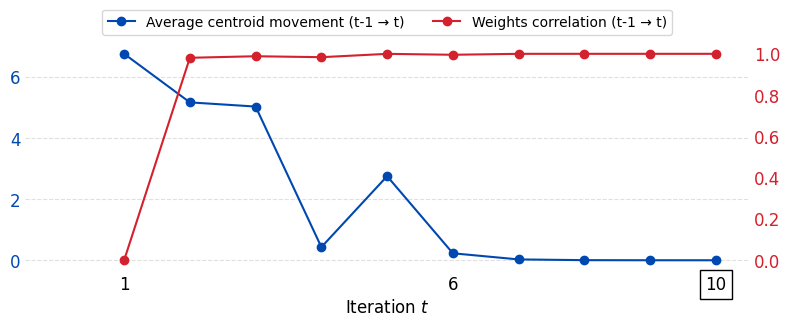

In [12]:
leuk_ = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_leuk,
    n_clusters=k_leuk)

In [13]:
leuk_res = evaluation(X_leuk, y_leuk, 'leukemia', k_leuk, range(0,10), True, 2)


Summary (means ± t-95% CI, SIL) on:  leukemia


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,2,0.204,"(0.163, 0.246)",0.174,"(0.142, 0.206)",0.194,"(0.147, 0.240)",0.198,"(0.158, 0.238)",0.226,"(0.150, 0.302)"



Summary (means ± t-95% CI, ACC) on: leukemia


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,2,0.672,"(0.647, 0.698)",0.672,"(0.615, 0.729)",0.674,"(0.614, 0.733)",0.639,"(0.589, 0.689)",0.717,"(0.692, 0.742)"



Summary (means ± t-95% CI, NMI) on: leukemia


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,2,0.066,"(0.034, 0.097)",0.111,"(0.060, 0.162)",0.098,"(0.046, 0.151)",0.048,"(0.018, 0.079)",0.123,"(0.095, 0.152)"



Summary (means ± t-95% CI, AMI) on: leukemia


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,2,0.054,"(0.020, 0.087)",0.101,"(0.048, 0.153)",0.087,"(0.032, 0.142)",0.036,"(0.004, 0.068)",0.112,"(0.081, 0.144)"



Summary (means ± t-95% CI, ARI) on: leukemia


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,2,0.097,"(0.055, 0.140)",0.123,"(0.048, 0.197)",0.121,"(0.036, 0.205)",0.064,"(0.010, 0.118)",0.171,"(0.121, 0.222)"



Summary (means ± t-95% CI, DB) on: leukemia


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,2,2.717,"(2.433, 3.000)",2.911,"(2.660, 3.163)",2.716,"(2.421, 3.010)",2.713,"(2.403, 3.022)",2.634,"(2.107, 3.160)"



Summary (mean runtime in seconds) on: leukemia


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,2,0.010,0.019,0.081,0.067,0.096


##### bbc

In [14]:
import numpy as np
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

bbc_ds = load_dataset("SetFit/bbc-news")
train_ds_bbc = bbc_ds["train"]
test_ds_bbc  = bbc_ds["test"]

texts_bbc = list(train_ds_bbc["text"]) + list(test_ds_bbc["text"])
labels_raw_bbc = list(train_ds_bbc["label"]) + list(test_ds_bbc["label"])
label_texts_bbc = list(train_ds_bbc["label_text"]) + list(test_ds_bbc["label_text"])

y_bbc = np.array(labels_raw_bbc, dtype=int)
k_bbc = len(np.unique(y_bbc))

label_map = {}
for lab, lab_txt in zip(labels_raw_bbc, label_texts_bbc):
    lab = int(lab)
    if lab not in label_map:
        label_map[lab] = lab_txt

print("Number of docs:", len(texts_bbc))
print("Label IDs:", sorted(label_map.keys()))
print("Label names:", [label_map[i] for i in sorted(label_map.keys())])

model = SentenceTransformer("all-MiniLM-L6-v2")
X_embed_bbc = model.encode(
    texts_bbc,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
)
print("BBC MiniLM embedding shape:", X_embed_bbc.shape)

pca = PCA(n_components=50, random_state=0)
X_bbc_embed_50 = pca.fit_transform(X_embed_bbc)
print("BBC MiniLM+PCA(50) shape:", X_bbc_embed_50.shape)

Number of docs: 2225
Label IDs: [0, 1, 2, 3, 4]
Label names: ['tech', 'business', 'sport', 'entertainment', 'politics']


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

BBC MiniLM embedding shape: (2225, 384)
BBC MiniLM+PCA(50) shape: (2225, 50)


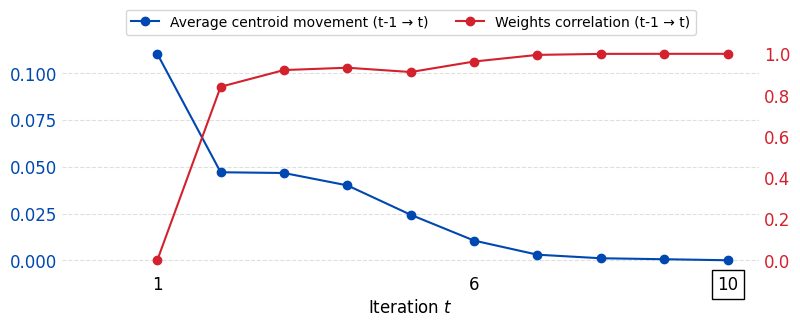

In [15]:
bbc_ = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_bbc_embed_50,
    n_clusters=k_bbc)

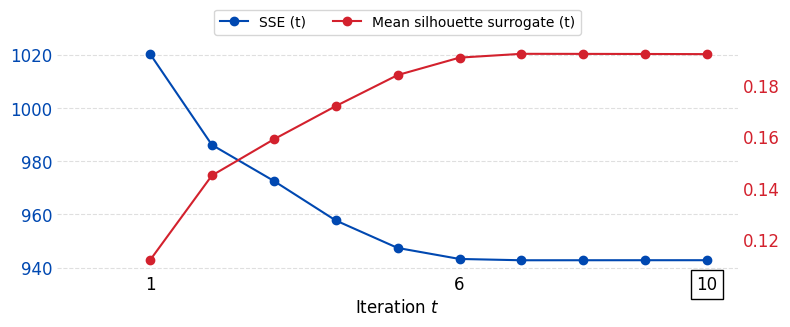

In [16]:
_ = run_ksil_and_plot_sse_and_sil_across_iterations(
    X_bbc_embed_50, k_bbc, use_weighted_sse=False
)

In [17]:
res_bbc =evaluation(
    X_bbc_embed_50,
    y_bbc,
    "BBC News",
    k_bbc,
    range(0, 25),
    True,
)


Summary (means ± t-95% CI, SIL) on:  BBC News


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,5,0.184,"(0.180, 0.187)",0.182,"(0.177, 0.186)",0.184,"(0.180, 0.188)",0.178,"(0.174, 0.182)",0.188,"(0.185, 0.191)"



Summary (means ± t-95% CI, ACC) on: BBC News


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,5,0.886,"(0.837, 0.935)",0.872,"(0.821, 0.923)",0.877,"(0.827, 0.927)",0.876,"(0.827, 0.925)",0.896,"(0.850, 0.942)"



Summary (means ± t-95% CI, NMI) on: BBC News


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,5,0.837,"(0.811, 0.862)",0.822,"(0.790, 0.854)",0.833,"(0.807, 0.859)",0.828,"(0.799, 0.856)",0.839,"(0.816, 0.863)"



Summary (means ± t-95% CI, AMI) on: BBC News


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,5,0.836,"(0.811, 0.862)",0.821,"(0.789, 0.853)",0.833,"(0.806, 0.859)",0.827,"(0.799, 0.856)",0.839,"(0.816, 0.862)"



Summary (means ± t-95% CI, ARI) on: BBC News


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,5,0.830,"(0.781, 0.879)",0.810,"(0.756, 0.864)",0.822,"(0.771, 0.872)",0.815,"(0.763, 0.866)",0.837,"(0.791, 0.884)"



Summary (means ± t-95% CI, DB) on: BBC News


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,5,2.644,"(2.616, 2.672)",2.688,"(2.631, 2.745)",2.651,"(2.621, 2.681)",2.655,"(2.623, 2.686)",2.636,"(2.611, 2.662)"



Summary (mean runtime in seconds) on: BBC News


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,5,0.003,0.020,0.159,0.025,0.043


##### Diabetes

In [18]:
data = fetch_openml("diabetes", version=1, as_frame=True)

X_d = data.data
y_d = data.target

le = LabelEncoder()
y_enc_d = le.fit_transform(y_d.to_numpy())

scaler = StandardScaler()
X_scaled_d = scaler.fit_transform(X_d.to_numpy(dtype=float))

n_clusters_d = len(np.unique(y_enc_d))

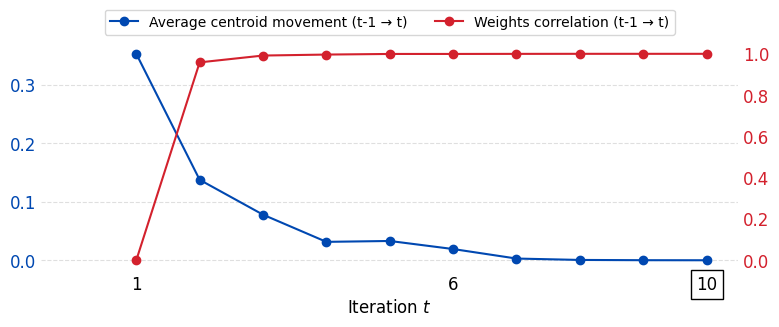

In [19]:
diab = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_scaled_d,
    n_clusters=n_clusters_d)

In [20]:
eval_diabetes = evaluation(
    X_scaled_d,
    y_enc_d,
    "Diabetes",
    n_clusters_d,
    range(0,10),
    True
)


Summary (means ± t-95% CI, SIL) on:  Diabetes


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,2,0.303,"(0.262, 0.345)",0.306,"(0.262, 0.350)",0.302,"(0.259, 0.346)",0.269,"(0.262, 0.276)",0.316,"(0.277, 0.356)"



Summary (means ± t-95% CI, ACC) on: Diabetes


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,2,0.684,"(0.666, 0.702)",0.684,"(0.666, 0.702)",0.683,"(0.666, 0.701)",0.688,"(0.671, 0.704)",0.699,"(0.683, 0.714)"



Summary (means ± t-95% CI, NMI) on: Diabetes


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,2,0.082,"(0.053, 0.112)",0.083,"(0.054, 0.111)",0.087,"(0.058, 0.116)",0.091,"(0.067, 0.115)",0.108,"(0.077, 0.138)"



Summary (means ± t-95% CI, AMI) on: Diabetes


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,2,0.081,"(0.052, 0.111)",0.082,"(0.053, 0.110)",0.086,"(0.057, 0.115)",0.090,"(0.066, 0.114)",0.107,"(0.076, 0.137)"



Summary (means ± t-95% CI, ARI) on: Diabetes


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,2,0.127,"(0.089, 0.165)",0.127,"(0.090, 0.164)",0.127,"(0.090, 0.163)",0.139,"(0.112, 0.165)",0.150,"(0.113, 0.188)"



Summary (means ± t-95% CI, DB) on: Diabetes


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,2,2.002,"(1.806, 2.198)",1.998,"(1.798, 2.198)",2.009,"(1.811, 2.207)",2.090,"(2.068, 2.113)",2.005,"(1.808, 2.202)"



Summary (mean runtime in seconds) on: Diabetes


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,2,0.002,0.009,0.111,0.018,0.043


##### Mice

In [21]:
from ucimlrepo import fetch_ucirepo

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer
import umap

mice_protein_expression = fetch_ucirepo(id=342)

X_full = mice_protein_expression.data.features
y_full = mice_protein_expression.data.targets


X_mice_df = X_full.select_dtypes(include=[np.number])

if "class" in y_full.columns:
    y_mice_txt = y_full["class"].values
else:
    y_mice_txt = y_full.iloc[:, -1].values

le = LabelEncoder()
y_mice = le.fit_transform(y_mice_txt)

imputer = SimpleImputer(strategy='mean')
X_mice_imputed = imputer.fit_transform(X_mice_df)

scaler = StandardScaler()
X_mice = scaler.fit_transform(X_mice_imputed)

k_mice = len(np.unique(y_mice))
name_mice = "Mice Protein"

reducer_mice = umap.UMAP(
    n_components=10,
    n_neighbors=15,
    min_dist=0.0,
    metric="euclidean",
    random_state=0
)

X_mice_umap = reducer_mice.fit_transform(X_mice)

print(f"Dataset: {name_mice}")
print(f"Shape: {X_mice_umap.shape}")
print(f"K: {k_mice}")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dataset: Mice Protein
Shape: (1080, 10)
K: 8


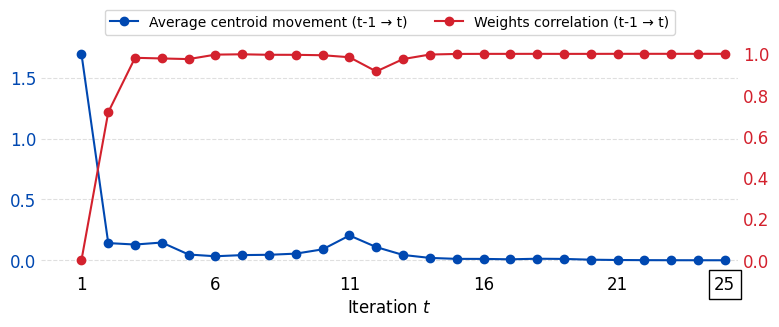

In [22]:
mice = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_mice_umap,
    n_clusters=k_mice
)

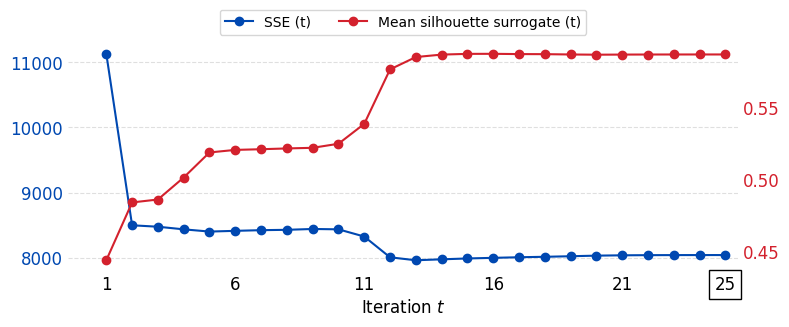

In [23]:
_ = run_ksil_and_plot_sse_and_sil_across_iterations(
    X_mice_umap, k_mice, use_weighted_sse=False
)

In [24]:
res = evaluation(X_mice_umap, y_mice, dataset_name=name_mice, k=k_mice, seeds=range(0,25), approx=True, temp=2)


Summary (means ± t-95% CI, SIL) on:  Mice Protein


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,8,0.564,"(0.539, 0.589)",0.560,"(0.534, 0.585)",0.559,"(0.533, 0.586)",0.556,"(0.531, 0.581)",0.612,"(0.593, 0.631)"



Summary (means ± t-95% CI, ACC) on: Mice Protein


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,8,0.382,"(0.373, 0.390)",0.381,"(0.370, 0.392)",0.388,"(0.377, 0.398)",0.383,"(0.374, 0.391)",0.393,"(0.385, 0.400)"



Summary (means ± t-95% CI, NMI) on: Mice Protein


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,8,0.421,"(0.409, 0.433)",0.420,"(0.406, 0.433)",0.429,"(0.419, 0.440)",0.419,"(0.406, 0.432)",0.444,"(0.434, 0.454)"



Summary (means ± t-95% CI, AMI) on: Mice Protein


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,8,0.414,"(0.401, 0.426)",0.412,"(0.399, 0.426)",0.422,"(0.412, 0.433)",0.411,"(0.398, 0.425)",0.437,"(0.427, 0.447)"



Summary (means ± t-95% CI, ARI) on: Mice Protein


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,8,0.223,"(0.211, 0.234)",0.221,"(0.209, 0.232)",0.230,"(0.218, 0.241)",0.222,"(0.209, 0.234)",0.243,"(0.232, 0.254)"



Summary (means ± t-95% CI, DB) on: Mice Protein


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,8,0.801,"(0.728, 0.873)",0.819,"(0.739, 0.900)",0.839,"(0.758, 0.920)",0.773,"(0.712, 0.833)",0.740,"(0.674, 0.805)"



Summary (mean runtime in seconds) on: Mice Protein


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,8,0.002,0.006,0.064,0.020,0.042


##### Wine

In [25]:
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = load_wine()
X_wine = data.data
y_wine = data.target
X_wine = StandardScaler().fit_transform(X_wine)

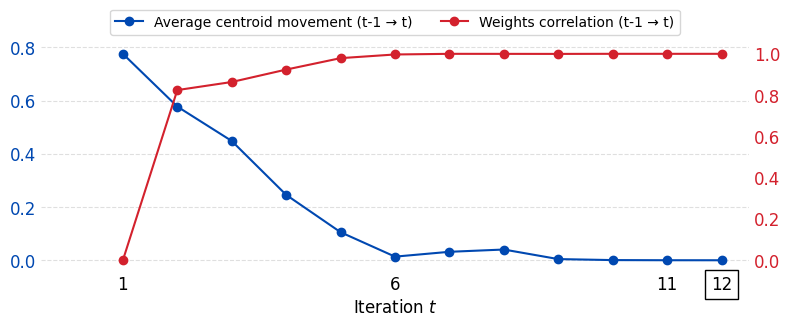

In [26]:
wine = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_wine,
    n_clusters=len(np.unique(y_wine))
)

In [27]:
results_wine = evaluation(X_wine , y_wine,'Wine', len(np.unique(y_wine)), range(0,25), approx=True, temp=2)


Summary (means ± t-95% CI, SIL) on:  Wine


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,3,0.411,"(0.402, 0.420)",0.410,"(0.394, 0.427)",0.418,"(0.409, 0.427)",0.397,"(0.389, 0.406)",0.430,"(0.430, 0.430)"



Summary (means ± t-95% CI, ACC) on: Wine


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,3,0.931,"(0.885, 0.978)",0.941,"(0.899, 0.983)",0.933,"(0.886, 0.981)",0.938,"(0.901, 0.974)",0.972,"(0.972, 0.973)"



Summary (means ± t-95% CI, NMI) on: Wine


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,3,0.839,"(0.791, 0.886)",0.855,"(0.809, 0.900)",0.843,"(0.796, 0.890)",0.835,"(0.800, 0.870)",0.893,"(0.891, 0.894)"



Summary (means ± t-95% CI, AMI) on: Wine


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,3,0.837,"(0.789, 0.885)",0.853,"(0.807, 0.899)",0.841,"(0.793, 0.889)",0.833,"(0.798, 0.868)",0.892,"(0.890, 0.893)"



Summary (means ± t-95% CI, ARI) on: Wine


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,3,0.846,"(0.784, 0.909)",0.868,"(0.811, 0.926)",0.854,"(0.792, 0.916)",0.844,"(0.798, 0.889)",0.914,"(0.913, 0.916)"



Summary (means ± t-95% CI, DB) on: Wine


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,3,1.417,"(1.345, 1.490)",1.448,"(1.365, 1.531)",1.414,"(1.345, 1.484)",1.422,"(1.354, 1.489)",1.389,"(1.389, 1.390)"



Summary (mean runtime in seconds) on: Wine


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,3,0.001,0.003,0.023,0.013,0.018


##### Breast Cancer

In [28]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = load_breast_cancer()
X_bc = data.data
y_bc = data.target

X_bc = StandardScaler().fit_transform(X_bc)

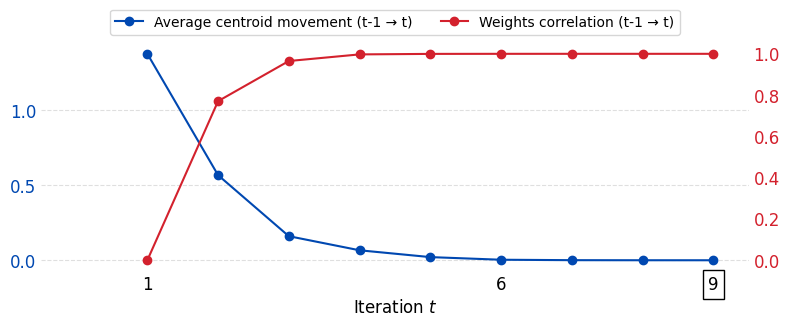

In [29]:
breast_cancer = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_bc,
    n_clusters=len(np.unique(y_bc))
)

In [30]:
results_bc = evaluation(X_bc, y_bc, 'Breast Cancer', len(np.unique(y_bc)), seed_range,approx=True, temp=2)


Summary (means ± t-95% CI, SIL) on:  Breast Cancer


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,2,0.471,"(0.470, 0.472)",0.467,"(0.466, 0.467)",0.467,"(0.467, 0.467)",0.453,"(0.453, 0.454)",0.492,"(0.492, 0.493)"



Summary (means ± t-95% CI, ACC) on: Breast Cancer


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,2,0.908,"(0.905, 0.910)",0.909,"(0.908, 0.910)",0.908,"(0.907, 0.909)",0.907,"(0.905, 0.910)",0.919,"(0.919, 0.919)"



Summary (means ± t-95% CI, NMI) on: Breast Cancer


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,2,0.542,"(0.533, 0.552)",0.546,"(0.542, 0.549)",0.542,"(0.540, 0.544)",0.542,"(0.531, 0.552)",0.594,"(0.594, 0.594)"



Summary (means ± t-95% CI, AMI) on: Breast Cancer


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,2,0.542,"(0.532, 0.551)",0.545,"(0.542, 0.548)",0.541,"(0.539, 0.543)",0.541,"(0.531, 0.552)",0.593,"(0.593, 0.593)"



Summary (means ± t-95% CI, ARI) on: Breast Cancer


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,2,0.662,"(0.654, 0.669)",0.666,"(0.664, 0.669)",0.664,"(0.661, 0.666)",0.660,"(0.652, 0.669)",0.700,"(0.700, 0.700)"



Summary (means ± t-95% CI, DB) on: Breast Cancer


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,2,1.317,"(1.314, 1.321)",1.320,"(1.317, 1.322)",1.321,"(1.321, 1.322)",1.316,"(1.313, 1.320)",1.304,"(1.304, 1.304)"



Summary (mean runtime in seconds) on: Breast Cancer


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,2,0.002,0.004,0.022,0.016,0.021


##### Vehicle

In [31]:
data_vehicle = fetch_openml(name="vehicle", version=1, as_frame=False)
X_vehicle_raw = data_vehicle.data
y_vehicle_txt = data_vehicle.target

le = LabelEncoder()
y_vehicle = le.fit_transform(np.asarray(y_vehicle_txt))

imputer = SimpleImputer(strategy='mean')
X_vehicle_imputed = imputer.fit_transform(X_vehicle_raw)

scaler = StandardScaler()
X_vehicle_scaled = scaler.fit_transform(X_vehicle_imputed)

reducer = umap.UMAP(n_components=15, n_neighbors=10, min_dist=0.0, random_state=42)
X_vehicle_umap = reducer.fit_transform(X_vehicle_scaled)

X_vehicle = X_vehicle_umap

k_vehicle = len(np.unique(y_vehicle))
name_vehicle = "Vehicle"

print(f"Dataset: {name_vehicle}")
print(f"Shape: {X_vehicle.shape}")
print(f"K: {k_vehicle}")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dataset: Vehicle
Shape: (846, 15)
K: 4


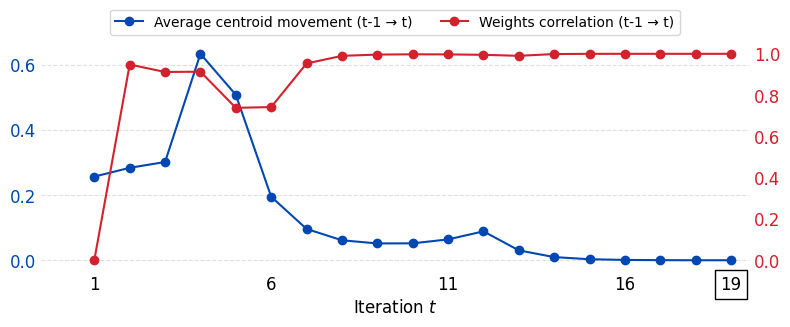

In [32]:
vh = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_vehicle,
    n_clusters=k_vehicle)

In [33]:
vehicle_res = evaluation(X_vehicle, y_vehicle, 'vehicle', k_vehicle, range(0,10), True)


Summary (means ± t-95% CI, SIL) on:  vehicle


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,4,0.587,"(0.555, 0.618)",0.589,"(0.560, 0.619)",0.588,"(0.557, 0.619)",0.575,"(0.547, 0.603)",0.602,"(0.572, 0.632)"



Summary (means ± t-95% CI, ACC) on: vehicle


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,4,0.413,"(0.397, 0.428)",0.418,"(0.402, 0.434)",0.413,"(0.398, 0.429)",0.412,"(0.399, 0.425)",0.428,"(0.414, 0.442)"



Summary (means ± t-95% CI, NMI) on: vehicle


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,4,0.163,"(0.150, 0.176)",0.168,"(0.154, 0.183)",0.163,"(0.150, 0.177)",0.168,"(0.156, 0.179)",0.172,"(0.158, 0.185)"



Summary (means ± t-95% CI, AMI) on: vehicle


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,4,0.160,"(0.146, 0.173)",0.165,"(0.150, 0.179)",0.160,"(0.146, 0.174)",0.164,"(0.153, 0.176)",0.169,"(0.155, 0.182)"



Summary (means ± t-95% CI, ARI) on: vehicle


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,4,0.116,"(0.109, 0.124)",0.120,"(0.112, 0.128)",0.117,"(0.109, 0.124)",0.114,"(0.105, 0.123)",0.125,"(0.118, 0.132)"



Summary (means ± t-95% CI, DB) on: vehicle


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,4,0.856,"(0.769, 0.944)",0.848,"(0.768, 0.927)",0.856,"(0.769, 0.944)",0.854,"(0.778, 0.929)",0.819,"(0.757, 0.880)"



Summary (mean runtime in seconds) on: vehicle


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,4,0.002,0.006,0.058,0.018,0.024


##### HTRU2

In [34]:
htru2 = fetch_ucirepo(id=372)
X_htru2 = htru2.data.features.to_numpy()
y_raw_htru2 = htru2.data.targets.iloc[:, 0]

le_htru2 = LabelEncoder()
y_htru2 = le_htru2.fit_transform(y_raw_htru2)
num_classes_htru2 = len(np.unique(y_htru2))

X_htru2_scaled = StandardScaler().fit_transform(X_htru2)
X_htru2 = X_htru2_scaled
y_htru2 = y_htru2
k_htru2 = num_classes_htru2
name_htru2 = "HTRU2"
print(f"Dataset: {name_htru2}\nShape: {X_htru2.shape}\nK: {k_htru2}")

Dataset: HTRU2
Shape: (17898, 8)
K: 2


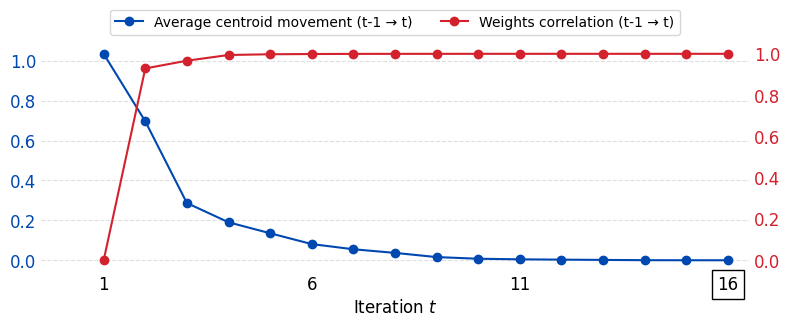

In [35]:
ht = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_htru2,
    n_clusters=k_htru2
)

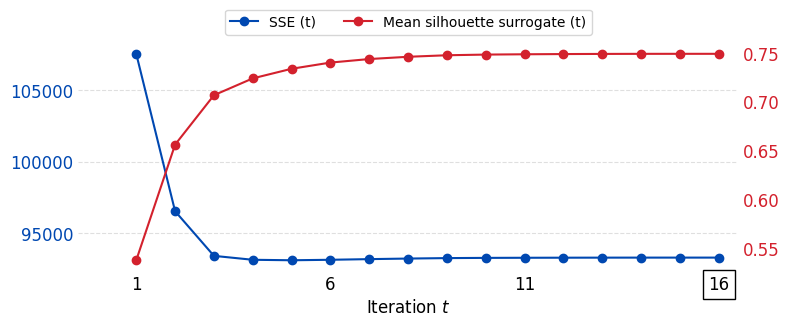

In [36]:
_ = run_ksil_and_plot_sse_and_sil_across_iterations(
    X_htru2, k_htru2, use_weighted_sse=False
)

In [37]:
htr_results = evaluation(X_htru2, y_htru2, dataset_name=name_htru2, k=k_htru2, seeds=seed_range, approx=True)


Summary (means ± t-95% CI, SIL) on:  HTRU2


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,2,0.684,"(0.667, 0.701)",0.679,"(0.666, 0.691)",0.684,"(0.667, 0.701)",0.653,"(0.653, 0.654)",0.749,"(0.749, 0.750)"



Summary (means ± t-95% CI, ACC) on: HTRU2


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,2,0.943,"(0.933, 0.952)",0.940,"(0.933, 0.947)",0.943,"(0.934, 0.952)",0.933,"(0.931, 0.934)",0.965,"(0.965, 0.965)"



Summary (means ± t-95% CI, NMI) on: HTRU2


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,2,0.442,"(0.387, 0.497)",0.423,"(0.382, 0.465)",0.442,"(0.387, 0.497)",0.391,"(0.386, 0.395)",0.572,"(0.571, 0.573)"



Summary (means ± t-95% CI, AMI) on: HTRU2


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,2,0.442,"(0.387, 0.497)",0.423,"(0.382, 0.465)",0.442,"(0.387, 0.497)",0.391,"(0.386, 0.395)",0.572,"(0.571, 0.573)"



Summary (means ± t-95% CI, ARI) on: HTRU2


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,2,0.635,"(0.593, 0.677)",0.621,"(0.589, 0.652)",0.635,"(0.593, 0.676)",0.590,"(0.585, 0.595)",0.722,"(0.721, 0.723)"



Summary (means ± t-95% CI, DB) on: HTRU2


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,2,0.992,"(0.896, 1.088)",1.024,"(0.951, 1.096)",0.991,"(0.895, 1.088)",1.072,"(1.067, 1.077)",0.690,"(0.689, 0.691)"



Summary (mean runtime in seconds) on: HTRU2


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,2,0.006,0.261,6.251,0.072,0.151


##### SMS

In [38]:
encoder_minilm = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def build_minilm_pca_features(
    texts,
    n_components=50,
    encoder=encoder_minilm,
    random_state=0,
):
    """
    texts -> MiniLM embeddings -> PCA(n_components) -> L2-normalized
    """
    X_emb = encoder.encode(
        list(map(str, texts)),
        convert_to_numpy=True,
        show_progress_bar=True
    ).astype(np.float64)

    pca = PCA(
        n_components=n_components,
        whiten=False,
        random_state=random_state
    )
    X_pca = pca.fit_transform(X_emb)

    normalizer = Normalizer(norm="l2", copy=False)
    X_final = normalizer.fit_transform(X_pca)

    return X_final, pca, normalizer

ds_sms = load_dataset("ucirvine/sms_spam", split="train")

texts_sms  = list(map(str, ds_sms["sms"]))
labels_sms_raw = list(ds_sms["label"])

le_sms = LabelEncoder()
y_sms = le_sms.fit_transform(labels_sms_raw)
k_sms = len(np.unique(y_sms))

print(f"SMS Spam: {len(texts_sms)} msgs, {k_sms} classes (ham/spam)")

X_sms_minilm, pca_sms, norm_sms_emb = build_minilm_pca_features(
    texts_sms,
    n_components=100,
    encoder=encoder_minilm,
    random_state=0,
)

SMS Spam: 5574 msgs, 2 classes (ham/spam)


Batches:   0%|          | 0/175 [00:00<?, ?it/s]

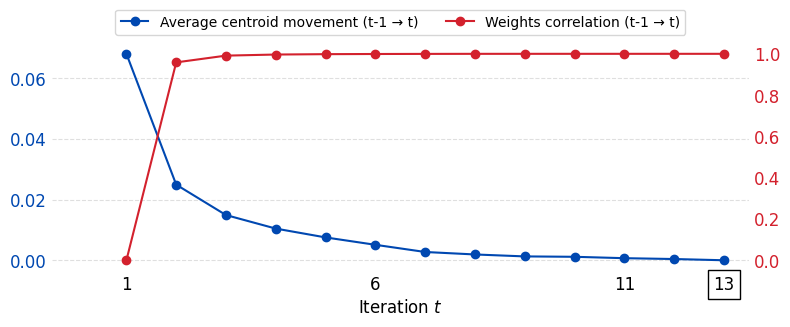

In [39]:
sms = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_sms_minilm,
    n_clusters=k_sms)

In [40]:
_ = evaluation(
    X_sms_minilm,
    y_sms,
    dataset_name="SMS",
    k=k_sms,
    seeds=range(0,25),
    approx=True, temp=2
)


Summary (means ± t-95% CI, SIL) on:  SMS


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,2,0.099,"(0.099, 0.099)",0.099,"(0.099, 0.099)",0.099,"(0.099, 0.099)",0.093,"(0.093, 0.093)",0.111,"(0.111, 0.111)"



Summary (means ± t-95% CI, ACC) on: SMS


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,2,0.845,"(0.845, 0.845)",0.845,"(0.845, 0.845)",0.845,"(0.845, 0.845)",0.834,"(0.833, 0.834)",0.860,"(0.860, 0.860)"



Summary (means ± t-95% CI, NMI) on: SMS


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,2,0.343,"(0.343, 0.343)",0.343,"(0.343, 0.343)",0.343,"(0.343, 0.343)",0.328,"(0.327, 0.329)",0.364,"(0.364, 0.364)"



Summary (means ± t-95% CI, AMI) on: SMS


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,2,0.343,"(0.343, 0.343)",0.343,"(0.343, 0.343)",0.343,"(0.343, 0.343)",0.328,"(0.327, 0.329)",0.364,"(0.364, 0.364)"



Summary (means ± t-95% CI, ARI) on: SMS


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,2,0.414,"(0.414, 0.414)",0.414,"(0.414, 0.414)",0.414,"(0.414, 0.414)",0.387,"(0.385, 0.389)",0.452,"(0.452, 0.452)"



Summary (means ± t-95% CI, DB) on: SMS


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,2,4.068,"(4.068, 4.069)",4.068,"(4.068, 4.068)",4.068,"(4.068, 4.068)",4.130,"(4.127, 4.134)",3.984,"(3.983, 3.984)"



Summary (mean runtime in seconds) on: SMS


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,2,0.011,0.105,0.963,0.079,0.107


##### MINDS-14

In [41]:
ds_minds_train = load_dataset("DeepPavlov/minds14", split="train")
ds_minds_test  = load_dataset("DeepPavlov/minds14", split="test")

texts_minds = (
    list(map(str, ds_minds_train["utterance"])) +
    list(map(str, ds_minds_test["utterance"]))
)
labels_minds_raw = (
    list(ds_minds_train["label"]) +
    list(ds_minds_test["label"])
)

le_minds = LabelEncoder()
y_minds = le_minds.fit_transform(labels_minds_raw)
k_minds = len(np.unique(y_minds))

print(f"MINDS-14: {len(texts_minds)} docs, {k_minds} classes")

X_minds_minilm, pca_minds, norm_minds_emb = build_minilm_pca_features(
    texts_minds,
    n_components=100,
    encoder=encoder_minilm,
    random_state=0,
)

MINDS-14: 539 docs, 14 classes


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

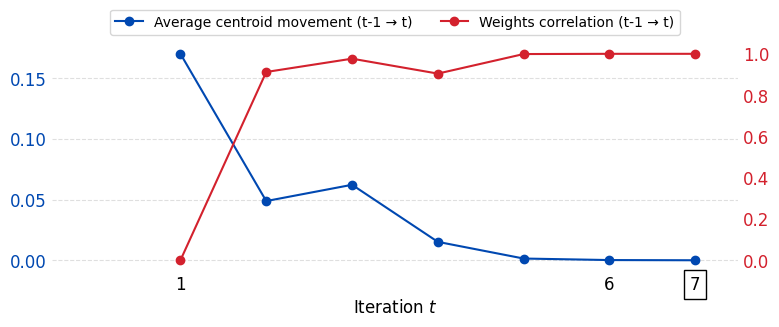

In [42]:
mind  = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_minds_minilm,
    n_clusters=k_minds
)

In [43]:
_ = evaluation(
    X_minds_minilm,
    y_minds,
    dataset_name="MINDS-14",
    k=k_minds,
    seeds=range(0,25),
    approx=True, temp=2
)


Summary (means ± t-95% CI, SIL) on:  MINDS-14


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,14,0.338,"(0.328, 0.348)",0.344,"(0.336, 0.351)",0.347,"(0.336, 0.357)",0.326,"(0.316, 0.336)",0.379,"(0.371, 0.387)"



Summary (means ± t-95% CI, ACC) on: MINDS-14


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,14,0.801,"(0.775, 0.826)",0.817,"(0.797, 0.837)",0.793,"(0.763, 0.822)",0.800,"(0.772, 0.827)",0.845,"(0.815, 0.874)"



Summary (means ± t-95% CI, NMI) on: MINDS-14


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,14,0.876,"(0.864, 0.887)",0.886,"(0.877, 0.895)",0.878,"(0.867, 0.889)",0.877,"(0.864, 0.889)",0.894,"(0.882, 0.906)"



Summary (means ± t-95% CI, AMI) on: MINDS-14


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,14,0.867,"(0.854, 0.879)",0.878,"(0.868, 0.888)",0.869,"(0.857, 0.881)",0.868,"(0.854, 0.881)",0.887,"(0.874, 0.899)"



Summary (means ± t-95% CI, ARI) on: MINDS-14


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,14,0.767,"(0.741, 0.792)",0.780,"(0.758, 0.801)",0.759,"(0.733, 0.785)",0.768,"(0.741, 0.796)",0.803,"(0.775, 0.832)"



Summary (means ± t-95% CI, DB) on: MINDS-14


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,14,1.904,"(1.853, 1.955)",1.891,"(1.852, 1.930)",1.885,"(1.834, 1.935)",1.911,"(1.858, 1.963)",1.785,"(1.749, 1.821)"



Summary (mean runtime in seconds) on: MINDS-14


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,14,0.003,0.006,0.088,0.022,0.046


##### Ionosphere

In [44]:
import os
import glob
import numpy as np
import pandas as pd
import kagglehub

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
import umap

path = kagglehub.dataset_download("prashant111/ionosphere")
print("Path to dataset files:", path)

csv_files = glob.glob(os.path.join(path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {path}")
csv_path = csv_files[0]
print("Using CSV:", csv_path)

df = pd.read_csv(csv_path)

y_ion_txt = df.iloc[:, -1].astype(str).values
X_ion_df = df.iloc[:, :-1]

X_ion_df = X_ion_df.select_dtypes(include=[np.number])
X_ion_raw = X_ion_df.to_numpy(dtype=np.float32)

le_ion = LabelEncoder()
y_ion = le_ion.fit_transform(y_ion_txt)
k_ion = len(np.unique(y_ion))
name_ion = "Ionosphere"

imputer_ion = SimpleImputer(strategy="mean")
X_ion_imputed = imputer_ion.fit_transform(X_ion_raw)

scaler_ion = StandardScaler()
X_ion_scaled = scaler_ion.fit_transform(X_ion_imputed)

reducer_ion = umap.UMAP(
    n_components=10,
    n_neighbors=10,
    min_dist=0.0,
    metric="euclidean",
    random_state=0,
)

X_ion_umap = reducer_ion.fit_transform(X_ion_scaled)

normalizer_ion = Normalizer(norm="l2", copy=False)
X_ion = normalizer_ion.fit_transform(X_ion_umap)

print(f"Dataset: {name_ion}")
print(f"Shape: {X_ion.shape}")
print(f"K: {k_ion}")


Using Colab cache for faster access to the 'ionosphere' dataset.
Path to dataset files: /kaggle/input/ionosphere
Using CSV: /kaggle/input/ionosphere/ionosphere_data.csv


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dataset: Ionosphere
Shape: (351, 10)
K: 2


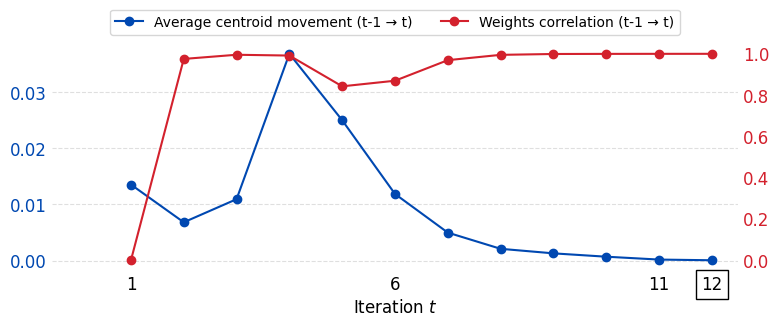

In [45]:
io = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_ion,
    n_clusters=k_ion)

In [46]:
ion_results = evaluation(
    X_ion,
    y_ion,
    "Ionosphere",
    k_ion,
    range(0,10),
    True
)


Summary (means ± t-95% CI, SIL) on:  Ionosphere


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,2,0.563,"(0.543, 0.584)",0.575,"(0.556, 0.594)",0.570,"(0.554, 0.586)",0.548,"(0.534, 0.563)",0.606,"(0.606, 0.606)"



Summary (means ± t-95% CI, ACC) on: Ionosphere


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,2,0.601,"(0.539, 0.664)",0.632,"(0.576, 0.688)",0.600,"(0.538, 0.661)",0.638,"(0.579, 0.698)",0.684,"(0.684, 0.684)"



Summary (means ± t-95% CI, NMI) on: Ionosphere


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,2,0.093,"(0.088, 0.099)",0.094,"(0.090, 0.099)",0.092,"(0.087, 0.097)",0.100,"(0.095, 0.105)",0.104,"(0.104, 0.104)"



Summary (means ± t-95% CI, AMI) on: Ionosphere


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,2,0.091,"(0.085, 0.097)",0.092,"(0.088, 0.097)",0.090,"(0.085, 0.095)",0.098,"(0.092, 0.103)",0.102,"(0.102, 0.102)"



Summary (means ± t-95% CI, ARI) on: Ionosphere


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,2,0.051,"(0.000, 0.113)",0.080,"(0.025, 0.136)",0.048,"(0.000, 0.109)",0.089,"(0.029, 0.149)",0.133,"(0.133, 0.133)"



Summary (means ± t-95% CI, DB) on: Ionosphere


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,2,0.893,"(0.854, 0.932)",0.871,"(0.835, 0.908)",0.892,"(0.852, 0.932)",0.874,"(0.844, 0.905)",0.836,"(0.836, 0.836)"



Summary (mean runtime in seconds) on: Ionosphere


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,2,0.002,0.003,0.017,0.018,0.018


##### R8

In [47]:
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import numpy as np

ds_r8 = load_dataset("dxgp/R8")
texts_r8 = ds_r8["train"]["text"]
labels_r8 = ds_r8["train"]["label"]

le = LabelEncoder()
y_r8 = le.fit_transform(labels_r8)
k_r8 = len(np.unique(y_r8))
name_r8 = "R8"

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

X_emb_r8 = model.encode(
    list(texts_r8),
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False,
)

print(f"Embeddings shape before PCA: {X_emb_r8.shape}")

pca = PCA(n_components=20, random_state=0)
X_r8_pca = pca.fit_transform(X_emb_r8)
y_r8 = y_r8

print(f"Dataset: {name_r8}, Shape after PCA: {X_r8_pca.shape}, k: {k_r8}")

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Embeddings shape before PCA: (4936, 384)
Dataset: R8, Shape after PCA: (4936, 20), k: 8


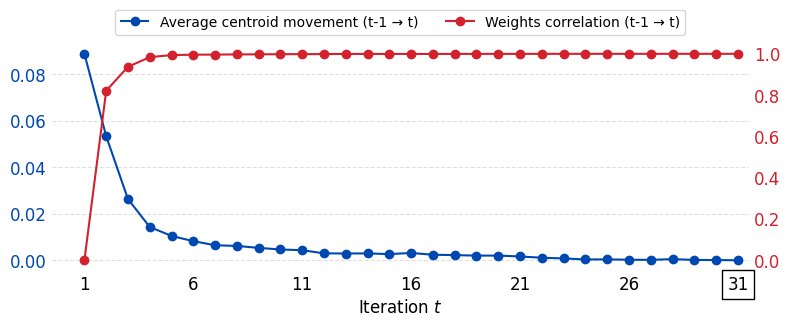

In [48]:
r = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_r8_pca,
    n_clusters=k_r8)

In [49]:
res = evaluation(
    X_r8_pca,
    y_r8,
    dataset_name=name_r8,
    k=k_r8,
    seeds=range(0, 10),
    approx=True,
)


Summary (means ± t-95% CI, SIL) on:  R8


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,8,0.242,"(0.234, 0.250)",0.244,"(0.237, 0.251)",0.242,"(0.235, 0.250)",0.224,"(0.215, 0.233)",0.252,"(0.243, 0.261)"



Summary (means ± t-95% CI, ACC) on: R8


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,8,0.491,"(0.441, 0.540)",0.491,"(0.466, 0.516)",0.482,"(0.448, 0.516)",0.460,"(0.419, 0.501)",0.504,"(0.458, 0.550)"



Summary (means ± t-95% CI, NMI) on: R8


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,8,0.519,"(0.498, 0.539)",0.522,"(0.503, 0.542)",0.520,"(0.499, 0.540)",0.509,"(0.483, 0.535)",0.527,"(0.506, 0.548)"



Summary (means ± t-95% CI, AMI) on: R8


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,8,0.517,"(0.497, 0.538)",0.521,"(0.501, 0.540)",0.518,"(0.498, 0.539)",0.507,"(0.481, 0.534)",0.525,"(0.504, 0.546)"



Summary (means ± t-95% CI, ARI) on: R8


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,8,0.349,"(0.313, 0.385)",0.352,"(0.331, 0.373)",0.344,"(0.315, 0.373)",0.320,"(0.283, 0.358)",0.359,"(0.326, 0.392)"



Summary (means ± t-95% CI, DB) on: R8


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,8,2.103,"(2.036, 2.170)",2.096,"(2.036, 2.156)",2.110,"(2.039, 2.182)",2.191,"(2.119, 2.263)",2.048,"(1.982, 2.113)"



Summary (mean runtime in seconds) on: R8


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,8,0.008,0.049,0.845,0.042,0.143


##### Banking77

In [50]:
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

ds_train = load_dataset("PolyAI/banking77", split="train", revision="refs/convert/parquet")
ds_test  = load_dataset("PolyAI/banking77", split="test",  revision="refs/convert/parquet")

texts_b77 = list(map(str, ds_train["text"])) + list(map(str, ds_test["text"]))
labels_b77_raw = list(ds_train["label"]) + list(ds_test["label"])

le = LabelEncoder()
y_b77 = le.fit_transform(labels_b77_raw)

k_b77 = len(np.unique(y_b77))
name_b77 = "BANKING77"

encoder_b77 = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X_b77_embed = encoder_b77.encode(
    texts_b77,
    convert_to_numpy=True,
    show_progress_bar=False
).astype(np.float64)

pca_b77 = PCA(
    n_components=50,
    whiten=False,
    random_state=0
)
X_b77_pca = pca_b77.fit_transform(X_b77_embed)

normalizer = Normalizer(norm="l2", copy=False)
X_b77 = normalizer.fit_transform(X_b77_pca)

print(f"Dataset: {name_b77}")
print(f"Shape: {X_b77.shape}")
print(f"K (true classes): {k_b77}")

Dataset: BANKING77
Shape: (13083, 50)
K (true classes): 77


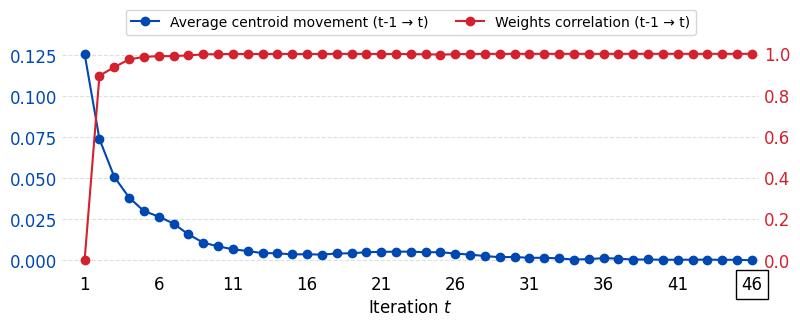

In [51]:
b7 = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_b77,
    n_clusters=k_b77)

In [52]:
pca_b77 = PCA(
    n_components=20,
    whiten=False,
    random_state=0
)

X_b77_pca = pca_b77.fit_transform(X_b77_embed)

normalizer = Normalizer(norm="l2", copy=False)
X_b77 = normalizer.fit_transform(X_b77_pca)

banking_results = evaluation(X_b77, y_b77, dataset_name=name_b77, k=k_b77, seeds=seed_range, approx=True)


Summary (means ± t-95% CI, SIL) on:  BANKING77


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,77,0.304,"(0.299, 0.309)",0.300,"(0.297, 0.303)",0.304,"(0.298, 0.309)",0.288,"(0.282, 0.294)",0.314,"(0.309, 0.319)"



Summary (means ± t-95% CI, ACC) on: BANKING77


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,77,0.546,"(0.535, 0.556)",0.542,"(0.534, 0.550)",0.545,"(0.534, 0.557)",0.538,"(0.525, 0.551)",0.553,"(0.542, 0.563)"



Summary (means ± t-95% CI, NMI) on: BANKING77


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,77,0.734,"(0.730, 0.739)",0.733,"(0.731, 0.735)",0.735,"(0.731, 0.739)",0.732,"(0.728, 0.736)",0.735,"(0.731, 0.739)"



Summary (means ± t-95% CI, AMI) on: BANKING77


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,77,0.718,"(0.713, 0.722)",0.716,"(0.714, 0.719)",0.719,"(0.714, 0.723)",0.716,"(0.712, 0.720)",0.719,"(0.715, 0.723)"



Summary (means ± t-95% CI, ARI) on: BANKING77


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,77,0.444,"(0.435, 0.452)",0.438,"(0.430, 0.446)",0.446,"(0.436, 0.455)",0.440,"(0.431, 0.449)",0.446,"(0.438, 0.454)"



Summary (means ± t-95% CI, DB) on: BANKING77


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,77,1.718,"(1.688, 1.747)",1.735,"(1.720, 1.749)",1.728,"(1.697, 1.759)",1.749,"(1.719, 1.779)",1.692,"(1.667, 1.716)"



Summary (mean runtime in seconds) on: BANKING77


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,77,0.057,0.220,3.190,0.656,2.248


##### CLINC150

In [53]:
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

ds_train = load_dataset("DeepPavlov/clinc150", split="train")
ds_val   = load_dataset("DeepPavlov/clinc150", split="validation")
ds_test  = load_dataset("DeepPavlov/clinc150", split="test")

texts_clinc = (
    list(map(str, ds_train["utterance"])) +
    list(map(str, ds_val["utterance"])) +
    list(map(str, ds_test["utterance"]))
)

labels_clinc_raw = (
    list(ds_train["label"]) +
    list(ds_val["label"]) +
    list(ds_test["label"])
)

le_clinc = LabelEncoder()
y_clinc = le_clinc.fit_transform(labels_clinc_raw)

k_clinc = len(np.unique(y_clinc))
name_clinc = "CLINC150"

encoder_clinc = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

X_clinc_embed = encoder_clinc.encode(
    texts_clinc,
    convert_to_numpy=True,
    show_progress_bar=True
).astype(np.float64)

pca_clinc = PCA(
    n_components=50,
    whiten=False,
    random_state=0
)
X_clinc_pca = pca_clinc.fit_transform(X_clinc_embed)

normalizer_clinc = Normalizer(norm="l2", copy=False)
X_clinc = normalizer_clinc.fit_transform(X_clinc_pca)

print(f"Dataset: {name_clinc}")
print(f"Shape: {X_clinc.shape}")
print(f"K (true classes): {k_clinc}")

Batches:   0%|          | 0/744 [00:00<?, ?it/s]

Dataset: CLINC150
Shape: (23800, 50)
K (true classes): 151


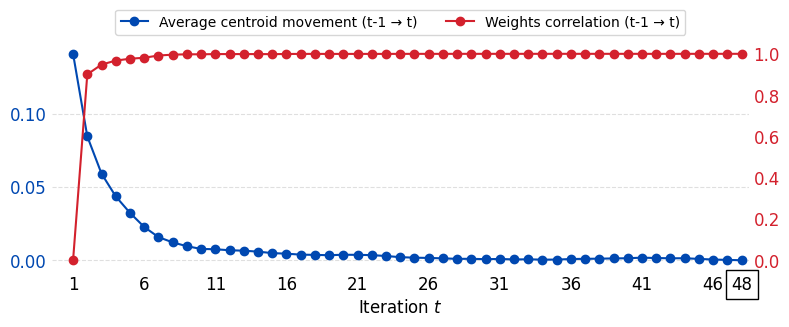

In [54]:
cl = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_clinc,
    n_clusters=k_clinc
)

In [55]:
results_clinc = evaluation(X_clinc, y_clinc, dataset_name=name_clinc, k=k_clinc, seeds=range(0,25), approx=True)


Summary (means ± t-95% CI, SIL) on:  CLINC150


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,151,0.286,"(0.284, 0.287)",0.288,"(0.286, 0.289)",0.287,"(0.286, 0.289)",0.274,"(0.273, 0.276)",0.294,"(0.293, 0.295)"



Summary (means ± t-95% CI, ACC) on: CLINC150


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,151,0.687,"(0.682, 0.693)",0.687,"(0.680, 0.694)",0.684,"(0.679, 0.689)",0.677,"(0.671, 0.682)",0.693,"(0.687, 0.698)"



Summary (means ± t-95% CI, NMI) on: CLINC150


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,151,0.858,"(0.857, 0.860)",0.858,"(0.857, 0.859)",0.859,"(0.858, 0.860)",0.855,"(0.853, 0.856)",0.859,"(0.858, 0.860)"



Summary (means ± t-95% CI, AMI) on: CLINC150


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,151,0.841,"(0.840, 0.843)",0.841,"(0.839, 0.842)",0.842,"(0.841, 0.844)",0.837,"(0.836, 0.839)",0.842,"(0.841, 0.844)"



Summary (means ± t-95% CI, ARI) on: CLINC150


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,151,0.548,"(0.545, 0.552)",0.548,"(0.544, 0.552)",0.548,"(0.545, 0.551)",0.540,"(0.536, 0.543)",0.552,"(0.549, 0.555)"



Summary (means ± t-95% CI, DB) on: CLINC150


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,151,2.027,"(2.015, 2.039)",2.012,"(2.000, 2.025)",2.033,"(2.021, 2.044)",2.055,"(2.044, 2.066)",2.004,"(1.994, 2.013)"



Summary (mean runtime in seconds) on: CLINC150


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,151,0.248,1.019,6.209,1.282,4.247


##### STL-10

In [56]:
import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.decomposition import PCA
!pip install git+https://github.com/openai/CLIP.git
import clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

ds_train = datasets.STL10(
    root="data",
    split="train",
    download=True,
    transform=clip_preprocess,
)

ds_test = datasets.STL10(
    root="data",
    split="test",
    download=True,
    transform=clip_preprocess,
)

full_dataset = ConcatDataset([ds_train, ds_test])

loader = DataLoader(
    full_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)


feats_list = []
labels_list = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        # CLIP image embeddings
        feats = clip_model.encode_image(imgs)

        feats = feats / feats.norm(dim=-1, keepdim=True).clamp(min=1e-12)

        feats_list.append(feats.cpu().numpy())
        labels_list.append(labels.numpy())

X_stl_raw = np.concatenate(feats_list, axis=0)
y_stl_raw = np.concatenate(labels_list, axis=0)

le = LabelEncoder()
y_stl = le.fit_transform(y_stl_raw)

pca_stl = PCA(
    n_components=100,
    whiten=False,
    random_state=0,
)
X_stl_pca = pca_stl.fit_transform(X_stl_raw)

normalizer = Normalizer(norm="l2", copy=False)
X_stl = normalizer.fit_transform(X_stl_pca)

k_stl = len(np.unique(y_stl))
name_stl = "STL-10"

print(f"Dataset: {name_stl}")
print(f"Shape: {X_stl.shape}")
print(f"K (true classes): {k_stl}")

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qv7fy9z7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qv7fy9z7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Dataset: STL-10
Shape: (13000, 100)
K (true classes): 10


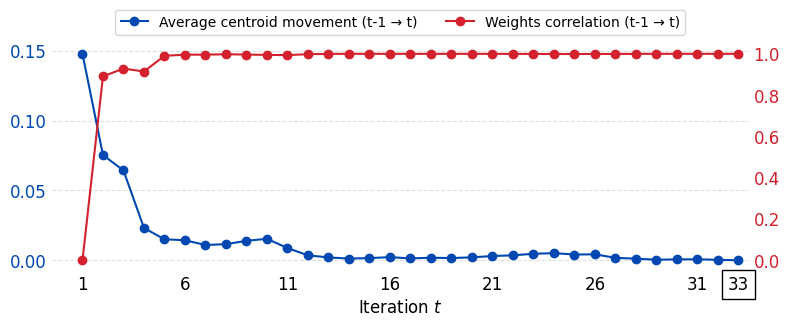

In [57]:
sl = run_ksil_and_plot_centroid_movement_and_weight_correlation(
    X_stl,
    n_clusters=k_stl
)

In [58]:
stl_results = evaluation(X_stl, y_stl, dataset_name="STL-10", k=k_stl, seeds=seed_range, approx=True)


Summary (means ± t-95% CI, SIL) on:  STL-10


,k,Mean SIL (k-means),95% CI (k-means),Mean SIL (LOFKMeans),95% CI (LOFKMeans),Mean SIL (iLOFKMeans),95% CI (iLOFKMeans),Mean SIL (OWKMeans),95% CI (OWKMeans),Mean SIL (K-Sil),95% CI (K-Sil)
0,10,0.257,"(0.245, 0.268)",0.264,"(0.255, 0.273)",0.258,"(0.247, 0.270)",0.250,"(0.238, 0.262)",0.265,"(0.254, 0.276)"



Summary (means ± t-95% CI, ACC) on: STL-10


,k,Mean ACC (k-means),95% CI (k-means),Mean ACC (LOFKMeans),95% CI (LOFKMeans),Mean ACC (iLOFKMeans),95% CI (iLOFKMeans),Mean ACC (OWKMeans),95% CI (OWKMeans),Mean ACC (K-Sil),95% CI (K-Sil)
0,10,0.843,"(0.763, 0.922)",0.858,"(0.794, 0.921)",0.840,"(0.760, 0.921)",0.832,"(0.754, 0.909)",0.859,"(0.789, 0.930)"



Summary (means ± t-95% CI, NMI) on: STL-10


,k,Mean NMI (k-means),95% CI (k-means),Mean NMI (LOFKMeans),95% CI (LOFKMeans),Mean NMI (iLOFKMeans),95% CI (iLOFKMeans),Mean NMI (OWKMeans),95% CI (OWKMeans),Mean NMI (K-Sil),95% CI (K-Sil)
0,10,0.894,"(0.863, 0.926)",0.893,"(0.869, 0.918)",0.894,"(0.862, 0.925)",0.888,"(0.858, 0.917)",0.899,"(0.872, 0.925)"



Summary (means ± t-95% CI, AMI) on: STL-10


,k,Mean AMI (k-means),95% CI (k-means),Mean AMI (LOFKMeans),95% CI (LOFKMeans),Mean AMI (iLOFKMeans),95% CI (iLOFKMeans),Mean AMI (OWKMeans),95% CI (OWKMeans),Mean AMI (K-Sil),95% CI (K-Sil)
0,10,0.894,"(0.863, 0.926)",0.893,"(0.869, 0.918)",0.893,"(0.862, 0.925)",0.887,"(0.857, 0.917)",0.899,"(0.872, 0.925)"



Summary (means ± t-95% CI, ARI) on: STL-10


,k,Mean ARI (k-means),95% CI (k-means),Mean ARI (LOFKMeans),95% CI (LOFKMeans),Mean ARI (iLOFKMeans),95% CI (iLOFKMeans),Mean ARI (OWKMeans),95% CI (OWKMeans),Mean ARI (K-Sil),95% CI (K-Sil)
0,10,0.820,"(0.741, 0.900)",0.829,"(0.771, 0.887)",0.819,"(0.739, 0.899)",0.806,"(0.730, 0.882)",0.836,"(0.767, 0.904)"



Summary (means ± t-95% CI, DB) on: STL-10


,k,Mean DB (k-means),95% CI (k-means),Mean DB (LOFKMeans),95% CI (LOFKMeans),Mean DB (iLOFKMeans),95% CI (iLOFKMeans),Mean DB (OWKMeans),95% CI (OWKMeans),Mean DB (K-Sil),95% CI (K-Sil)
0,10,2.168,"(2.075, 2.261)",2.118,"(2.042, 2.193)",2.171,"(2.078, 2.265)",2.181,"(2.078, 2.285)",2.127,"(2.039, 2.214)"



Summary (mean runtime in seconds) on: STL-10


,k,Mean Time (s) (k-means),Mean Time (s) (LOFKMeans),Mean Time (s) (iLOFKMeans),Mean Time (s) (OWKMeans),Mean Time (s) (K-Sil)
0,10,0.083,0.493,2.335,0.613,1.244


##### vs $k$-means++ initialization

In [59]:
name_list = ['Lkm',
             'Inr',
             'Dbt',
             'MiP',
             'Wne',
             'BrC',
             'Vcl',
             'Htr',
             'Sms',
             'Mds',
             'Bbc',
             'Re8',
             'B77',
             'Clc',
             'Stl']

labels_sc = [rf"$\textsc{{{n}}}$" for n in name_list]

X_list = [X_leuk,
          X_ion,
          X_scaled_d,
          X_mice_umap,
          X_wine,
          X_bc,
          X_vehicle,
          X_htru2,
          X_sms_minilm,
          X_minds_minilm,
          X_bbc_embed_50,
          X_r8_pca,
          X_b77,
          X_clinc,
          X_stl]

y_list = [y_leuk,
          y_ion,
          y_enc_d,
          y_mice,
          y_wine,
          y_bc,
          y_vehicle,
          y_htru2,
          y_sms,
          y_minds,
          y_bbc,
          y_r8,
          y_b77,
          y_clinc,
          y_stl]

k_list = []
for y in y_list:
    k_y = len(np.unique(y))
    k_list.append(k_y)

def check_dims(X_list,y_list,k_list, pr=False):
    for X, y, k in zip(X_list, y_list, k_list):
        if pr:
           print(X.shape[0], len(y), k)
        if X.shape[0]!=len(y) or k!=len(np.unique(y)):
            return False
    return True

print(check_dims(X_list,y_list,k_list, pr=False))

tau0list=[X_wine, X_bc, X_sms_minilm, X_leuk]

True


In [60]:
def _evaluate_clustering(X, y_true, y_pred, centers):

    sil = Silhouette.MicroApprox(X, y_pred, centers)
    db  = davies_bouldin_score(X, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = NMI(y_true, y_pred)
    return dict(sil=sil, db=db, ari=ari, nmi=nmi)

def run_kmeanspp_ksil_relative(
    X_list,
    y_list,
    k_list,
    KSil_cls,
    seed=0,
    n_runs=20,
    eps=1e-8,
    return_raw=True,
):
    metrics = ["sil", "db", "ari", "nmi"]

    km_metrics_all   = {m: [] for m in metrics}
    ksil_metrics_all = {m: [] for m in metrics}

    for X, y, k in zip(X_list, y_list, k_list):
        km_runs   = {m: [] for m in metrics}
        ksil_runs = {m: [] for m in metrics}

        for r in range(n_runs):
            rs = seed + r

            km = KMeans(
                n_clusters=k,
                init="k-means++",
                random_state=rs,
                n_init=1,
            ).fit(X)
            km_m = _evaluate_clustering(X, y, km.labels_, km.cluster_centers_)
            for m in metrics:
                km_runs[m].append(km_m[m])

            temp = 2 if any(X is A for A in tau0list) else 1
            ksil = KSil_cls(
                n_clusters=k,
                init="k-means++",
                n_init=1,
                random_state=rs,
                init_temperature=temp
            ).fit(X)
            ks_m = _evaluate_clustering(X, y, ksil.labels_, ksil.cluster_centers_)
            for m in metrics:
                ksil_runs[m].append(ks_m[m])

        for m in metrics:
            km_metrics_all[m].append(float(np.mean(km_runs[m])))
            ksil_metrics_all[m].append(float(np.mean(ksil_runs[m])))

    rel_improv = {}
    for m in metrics:
        km_vals   = np.array(km_metrics_all[m], dtype=float)
        ksil_vals = np.array(ksil_metrics_all[m], dtype=float)

        num = (km_vals - ksil_vals) if m == "db" else (ksil_vals - km_vals)
        denom = np.maximum(np.abs(km_vals), eps)
        rel_improv[m] = 100.0 * num / denom

    return (rel_improv, km_metrics_all, ksil_metrics_all) if return_raw else rel_improv

rel_improv, km_res, ksil_res = run_kmeanspp_ksil_relative(
    X_list=X_list,
    y_list=y_list,
    k_list=k_list,
    KSil_cls=KSil,
    seed=42,
    n_runs=120,
)

# Per-metric summary over all datasets
print("=== Per-metric relative improvement (averaged over runs) ===")
for m, vals in rel_improv.items():
    vals = np.array(vals)
    print(
        f"{m.upper():3}  mean={np.mean(vals):8.2f}%  "
        f"median={np.median(vals):8.2f}%  "
        f"min={np.min(vals):8.2f}%  max={np.max(vals):8.2f}%"
    )

# Per-dataset improvements
metrics = ["sil", "db", "ari", "nmi"]
print("\n=== Per-dataset relative improvement ===")
for i, name in enumerate(name_list):
    line = [f"{name}:"]
    for m in metrics:
        line.append(f"{m.upper()}={rel_improv[m][i]:8.2f}%")
    print("  " + "  ".join(line))

bar_metrics = ["sil", "db", "ari", "nmi"]

titles = [
    r"SIL relative (%)",
    r"DB relative (%)",
    r"ARI relative (%)",
    r"NMI relative (%)",
]

=== Per-metric relative improvement (averaged over runs) ===
SIL  mean=    3.86%  median=    3.09%  min=    1.50%  max=   11.63%
DB   mean=    2.67%  median=    0.77%  min=   -1.14%  max=   24.04%
ARI  mean=    9.80%  median=    4.02%  min=   -0.20%  max=   72.86%
NMI  mean=    8.29%  median=    1.92%  min=   -0.19%  max=   55.84%

=== Per-dataset relative improvement ===
  Lkm:  SIL=    2.27%  DB=   -1.14%  ARI=   72.86%  NMI=   55.84%
  Inr:  SIL=    4.02%  DB=    2.32%  ARI=   22.18%  NMI=    6.30%
  Dbt:  SIL=    5.17%  DB=    0.20%  ARI=   16.42%  NMI=   24.12%
  MiP:  SIL=    1.50%  DB=    4.73%  ARI=    1.57%  NMI=    0.73%
  Wne:  SIL=    3.42%  DB=    0.12%  ARI=    3.45%  NMI=    2.90%
  BrC:  SIL=    4.31%  DB=    0.73%  ARI=    4.78%  NMI=    7.85%
  Vcl:  SIL=    2.00%  DB=    2.01%  ARI=    4.02%  NMI=    1.92%
  Htr:  SIL=    7.19%  DB=   24.04%  ARI=    7.88%  NMI=   17.42%
  Sms:  SIL=   11.63%  DB=    2.08%  ARI=    9.19%  NMI=    6.10%
  Mds:  SIL=    2.74%  DB=    0

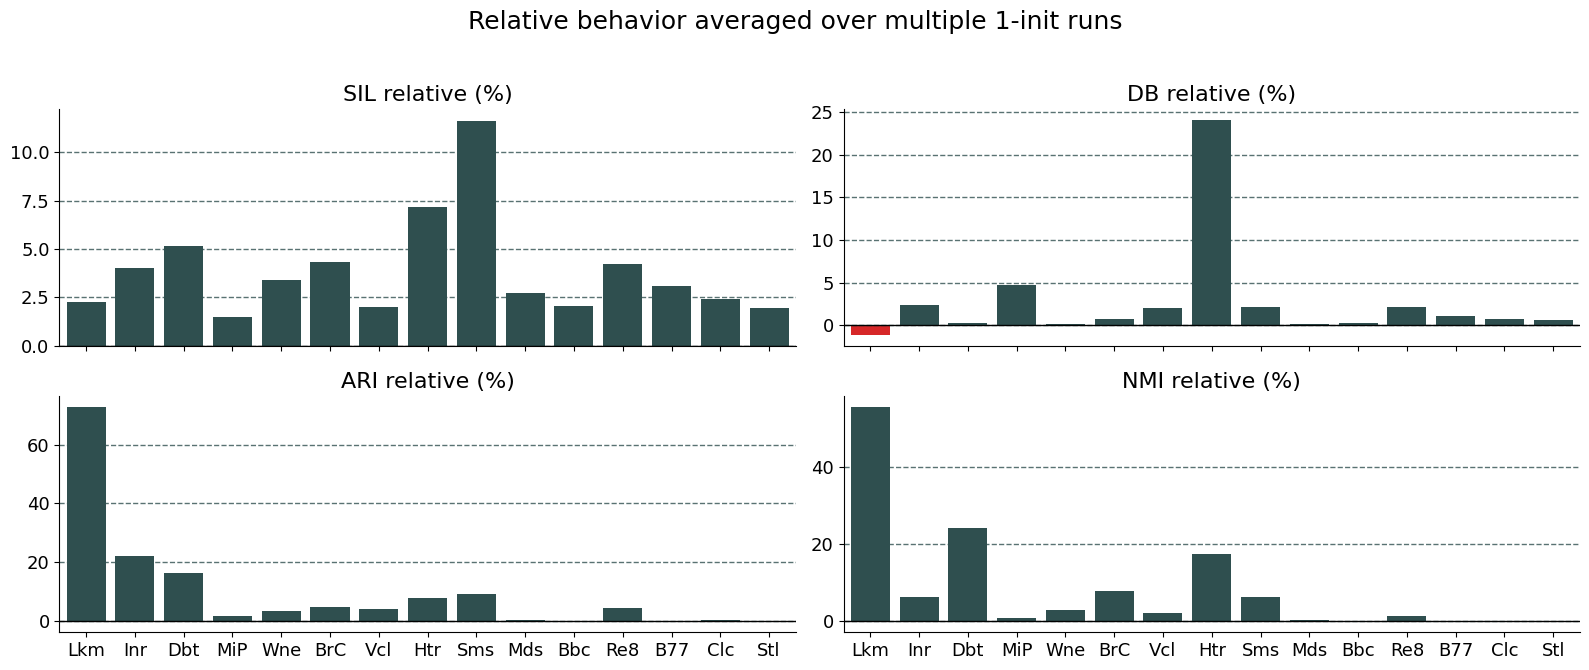

In [61]:
labels_sc = name_list

titles = [
    r"SIL relative (%)",
    r"DB relative (%)",
    r"ARI relative (%)",
    r"NMI relative (%)",
]

x = np.arange(len(name_list))

tick_fs   = 13
title_fs  = 16
supt_fs   = 18

labels_sc = labels_sc

fig, axes = plt.subplots(2, 2, figsize=(16, 7), sharex=True)
axes = axes.ravel()

for ax, m, title in zip(axes, bar_metrics, titles):
    vals = np.array(rel_improv[m])
    ax.grid(True, axis="y", linestyle="--", linewidth=1, color="darkslategray", alpha=0.8)
    cols = np.where(vals < 0, "tab:red", "darkslategray")
    ax.bar(x, vals, width=0.8, color=cols)
    ax.margins(x=0.01)
    ax.axhline(0, color="k", lw=1)
    ax.set_title(title, fontsize=title_fs)
    ax.set_ylabel("")
    ax.set_xticks(x)
    ax.set_xticklabels(labels_sc, rotation=0, ha="center", fontsize=tick_fs, fontvariant="small-caps")
    ax.tick_params(axis="y", labelsize=tick_fs)
    for s in ["top","right"]:
        ax.spines[s].set_visible(False)

fig.suptitle("Relative behavior averaged over multiple 1-init runs", fontsize=supt_fs)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

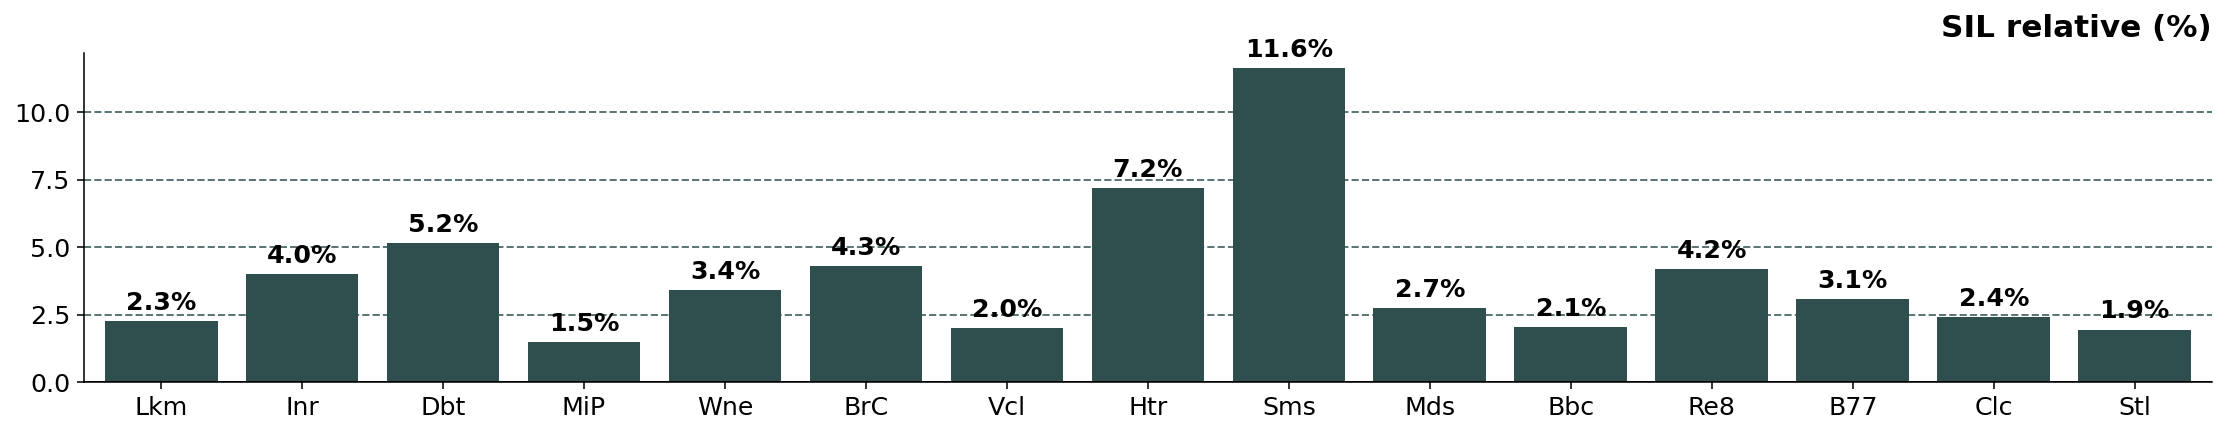

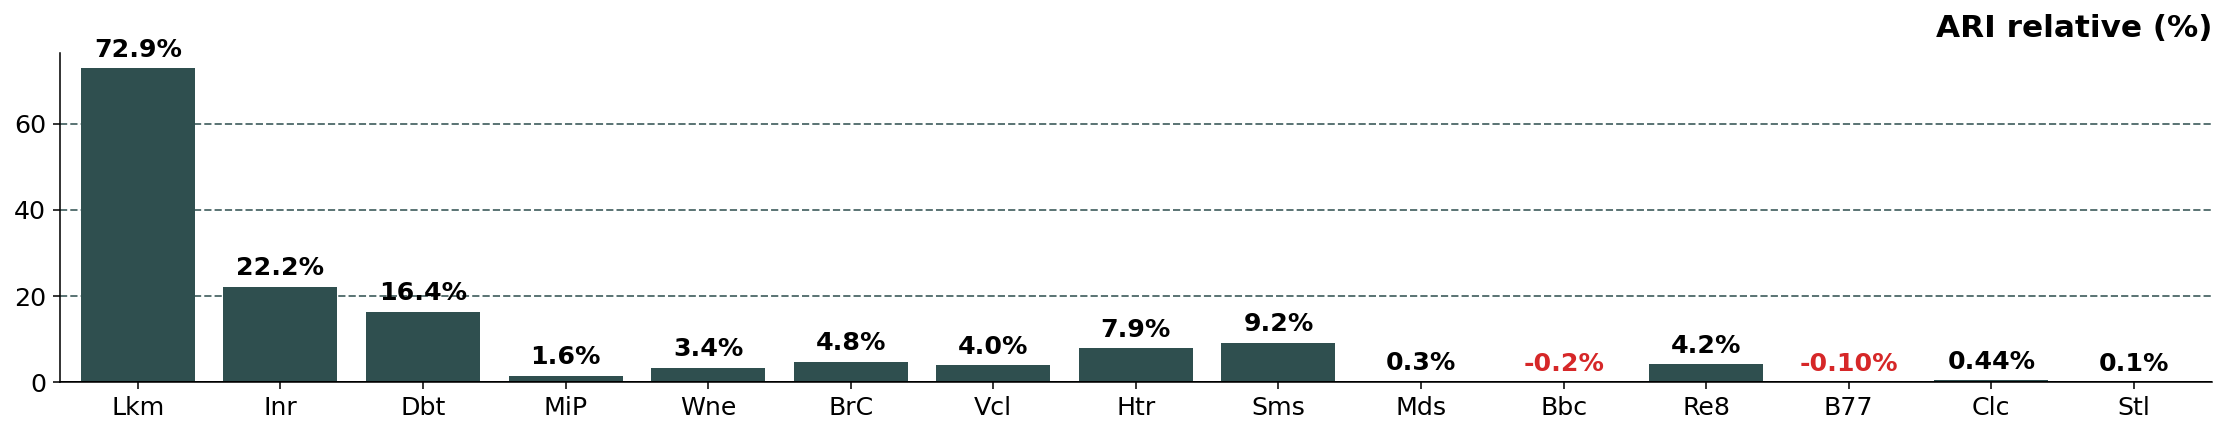

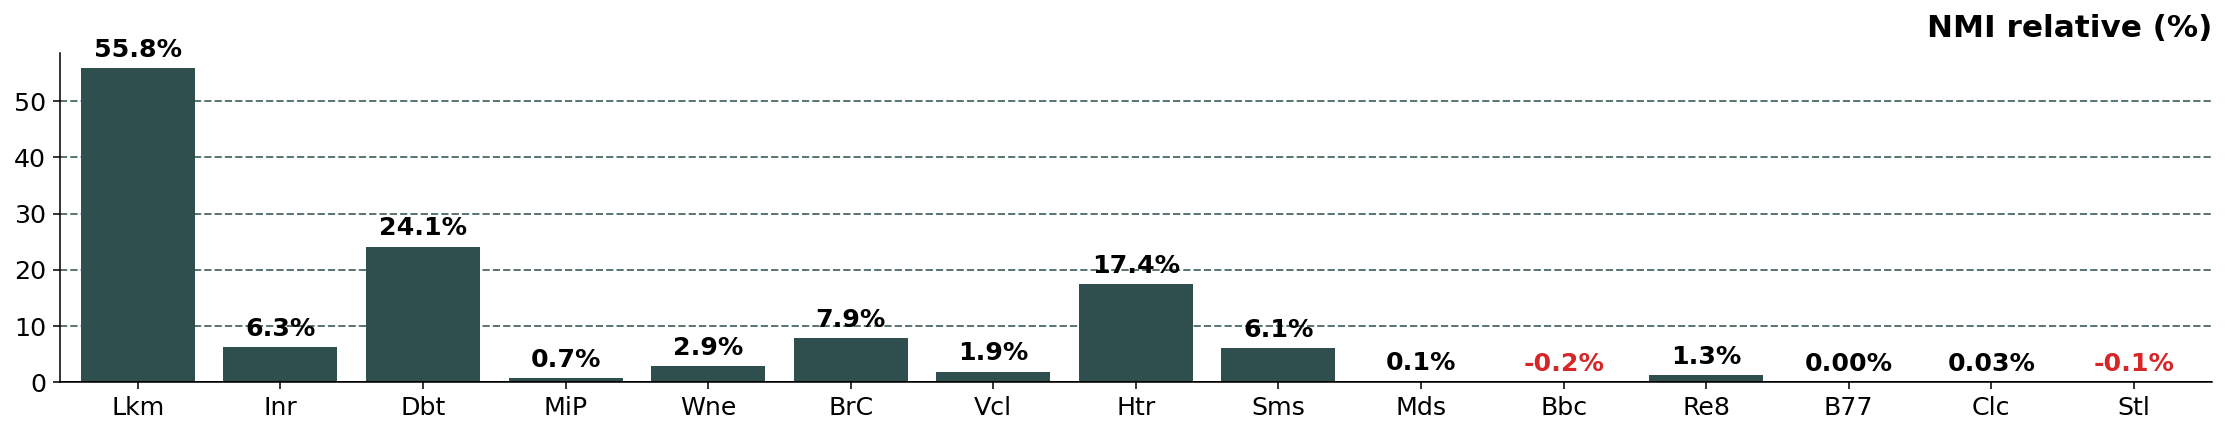

In [62]:
labels_sc = name_list
x = np.arange(len(name_list))

tick_fs, title_fs, lab_fs = 13, 16, 13
dec = 1

def fmt_pct(v, dec=1):
    r = round(float(v), dec)
    if abs(r) < 0.5 * 10**(-dec):
        r = 0.0
    if r == 0:
        return "0%"
    return f"{r:.{dec}f}%"

idx_b77 = name_list.index("B77")
idx_clc = name_list.index("Clc")

thr1 = 0.5 * 10**(-dec)
thr2 = 0.005

for m, title in [("sil", "SIL relative (%)"), ("ari", "ARI relative (%)"), ("nmi", "NMI relative (%)")]:
    fig, ax = plt.subplots(figsize=(16, 3.2), dpi=140)

    vals = np.asarray(rel_improv[m], float)
    h = np.maximum(vals, 0.0)

    ax.grid(True, axis="y", linestyle="--", linewidth=1, color="darkslategray", alpha=0.8)

    cols = np.where(vals < 0, "tab:red", "darkslategray")
    bars = ax.bar(x, h, width=0.8, color=cols)

    ax.margins(x=0.01)
    ax.axhline(0, color="k", lw=1)
    ax.set_title(title, fontsize=title_fs, fontweight="bold", loc="right", pad=8)
    ax.set_ylabel("")
    ax.set_xticks(x)
    ax.set_xticklabels(labels_sc, rotation=0, ha="center", fontsize=tick_fs, fontvariant="small-caps")
    ax.tick_params(axis="y", labelsize=tick_fs)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)

    pad = 0.02 * (np.nanmax(np.abs(vals)) + 1e-12)

    for i, (b, v, hh) in enumerate(zip(bars, vals, h)):
        special = (m in ("ari", "nmi")) and (i in (idx_b77, idx_clc))

        if special:
            v_eff = 0.0 if abs(v) < thr2 else v
            if abs(v_eff) < thr1:
                txt = f"{max(v_eff, 0.0):.2f}%"
            else:
                txt = f"{v_eff:.2f}%"
        else:
            v_eff = 0.0 if abs(v) < thr1 else v
            txt = fmt_pct(v_eff, dec)

        if v_eff < 0:
            y, va, c = pad, "bottom", "tab:red"
        else:
            y, va, c = hh + pad, "bottom", "black"

        ax.text(
            b.get_x() + b.get_width() / 2,
            y,
            txt,
            ha="center",
            va=va,
            fontsize=lab_fs,
            fontweight="bold",
            color=c,
        )

    fig.tight_layout()
    plt.show()

### Stress-tests (Outliers $\sim$ Replacement/Injection)


[stor 00] MiP: X=(1080, 10), k=8, renorm_l2=False

[stor 01] Re8: X=(4936, 20), k=8, renorm_l2=False

[stio 00] MiP: X=(1080, 10), k=8, renorm_l2=False

[stio 01] Re8: X=(4936, 20), k=8, renorm_l2=False


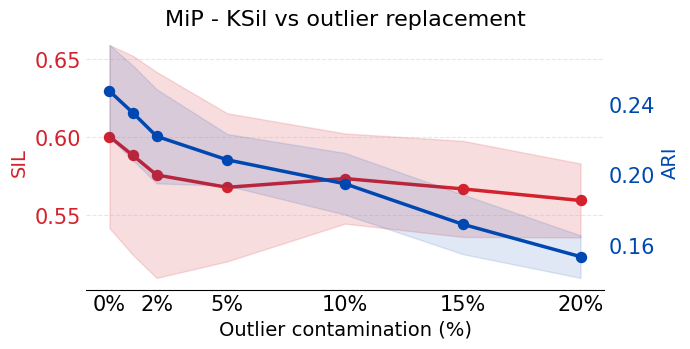

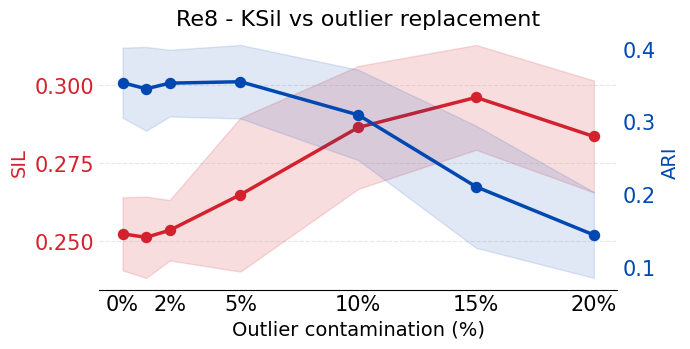

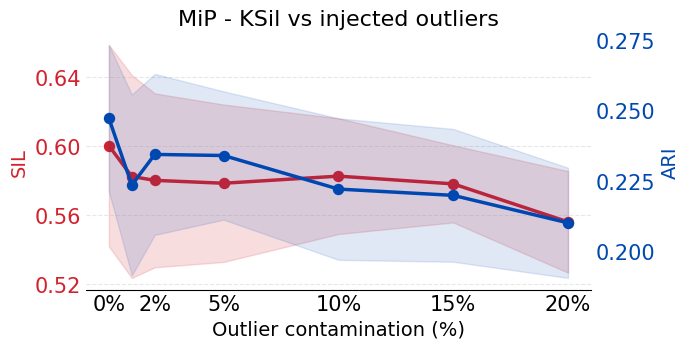

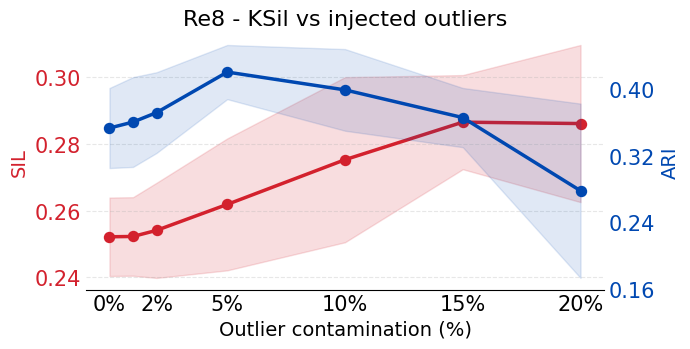

In [63]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import adjusted_rand_score

name_list = ['MiP', 'Re8']
labels_sc = [rf"$\textsc{{{n}}}$" for n in name_list]

X_list = [X_mice_umap, X_r8_pca]
y_list = [y_mice, y_r8]

k_list = [len(np.unique(y)) for y in y_list]


eps_grid = (0.0, 0.01, 0.02, 0.05, 0.10, 0.15, 0.20)
seeds = range(0, 20)
outlier_scale = 8.0

renorm_idxs = []

ksil_kwargs = dict(
    init="random",
    max_iter=100,
    learning_rate=0.2,
    tol=1e-4,
    n_init=1,
)

def _as_array(X):
    return X.values if hasattr(X, "values") else np.asarray(X, dtype=float)

def inject_outliers_replacement(X, eps, seed=0, outlier_scale=8.0, renorm_l2=False):
    X = _as_array(X).astype(float, copy=True)
    n, d = X.shape
    rng = np.random.RandomState(seed)

    m = int(round(eps * n))
    idx = rng.choice(n, size=m, replace=False) if m > 0 else np.array([], dtype=int)

    mu = X.mean(axis=0)
    sd = X.std(axis=0) + 1e-12

    Xc = X.copy()
    if m > 0:
        Z = rng.randn(m, d)
        Xc[idx] = mu + outlier_scale * sd * Z

    if renorm_l2:
        norms = np.linalg.norm(Xc, axis=1, keepdims=True)
        Xc = Xc / np.clip(norms, 1e-12, None)

    return Xc

def inject_outliers_append(X, eps, seed=0, outlier_scale=8.0, renorm_l2=False):
    X = _as_array(X).astype(float, copy=True)
    n, d = X.shape
    rng = np.random.RandomState(seed)

    m = int(round(eps * n))
    if m <= 0:
        return X

    mu = X.mean(axis=0)
    sd = X.std(axis=0) + 1e-12

    Z = rng.randn(m, d)
    outliers = mu + outlier_scale * sd * Z

    X_aug = np.vstack([X, outliers])

    if renorm_l2:
        norms = np.linalg.norm(X_aug, axis=1, keepdims=True)
        X_aug = X_aug / np.clip(norms, 1e-12, None)

    return X_aug

def micro_sil_from_sil_scores(X, labels, centers):
    labels = np.asarray(labels, dtype=int)
    K = centers.shape[0]
    counts = np.bincount(labels, minlength=K)

    s_vals, _, _ = KSil.sil_scores(X, labels, centers)

    singleton_mask = (counts[labels] <= 1)
    if np.any(singleton_mask):
        s_vals = np.asarray(s_vals, dtype=float)
        s_vals[singleton_mask] = 0.0

    return float(np.mean(s_vals))

def eval_ksil_on_X_replacement(X, y, k, seed=0, ksil_kwargs=None):
    if ksil_kwargs is None:
        ksil_kwargs = {}

    t0 = time.perf_counter()
    ks = KSil(n_clusters=int(k), random_state=int(seed), **ksil_kwargs).fit(X)
    t = time.perf_counter() - t0

    labels = ks.labels_.astype(int)
    centers = ks.cluster_centers_

    sil = micro_sil_from_sil_scores(X, labels, centers)
    ari = float(adjusted_rand_score(y, labels))

    return dict(sil=float(sil), ari=float(ari), time_s=float(t),
                n_iter=int(ks.n_iter_ if ks.n_iter_ is not None else -1))

def eval_ksil_on_X_append(X_aug, y, k, seed=0, ksil_kwargs=None):
    if ksil_kwargs is None:
        ksil_kwargs = {}

    t0 = time.perf_counter()
    ks = KSil(n_clusters=int(k), random_state=int(seed), **ksil_kwargs).fit(X_aug)
    t = time.perf_counter() - t0

    labels = ks.labels_.astype(int)
    centers = ks.cluster_centers_

    sil = micro_sil_from_sil_scores(X_aug, labels, centers)
    ari = float(adjusted_rand_score(y, labels[:len(y)]))

    return dict(sil=float(sil), ari=float(ari), time_s=float(t),
                n_iter=int(ks.n_iter_ if ks.n_iter_ is not None else -1))

def run_ksil_stress_replacement(
    X_list, y_list, k_list, dataset_names,
    eps_grid, seeds=range(0, 20),
    outlier_scale=8.0, renorm_embeddings_for=None,
    ksil_kwargs=None, verbose=True
):
    if renorm_embeddings_for is None:
        renorm_embeddings_for = []
    renorm_set = set(renorm_embeddings_for)

    rows = []
    for di, (name, X, y, k) in enumerate(zip(dataset_names, X_list, y_list, k_list)):
        X = _as_array(X)
        y = np.asarray(y)
        k = int(k)
        renorm_l2 = (di in renorm_set)

        if verbose:
            print(f"\n[stor {di:02d}] {name}: X={X.shape}, k={k}, renorm_l2={renorm_l2}")

        for eps in eps_grid:
            for seed in seeds:
                Xc = inject_outliers_replacement(
                    X, eps=float(eps), seed=int(seed),
                    outlier_scale=float(outlier_scale), renorm_l2=renorm_l2
                )
                res = eval_ksil_on_X_replacement(Xc, y, k, seed=seed, ksil_kwargs=ksil_kwargs)
                rows.append({"dataset": name, "dataset_idx": di, "eps": float(eps), "seed": int(seed), **res})

    return pd.DataFrame(rows)

def run_ksil_stress_append(
    X_list, y_list, k_list, dataset_names,
    eps_grid, seeds=range(0, 20),
    outlier_scale=8.0, renorm_embeddings_for=None,
    ksil_kwargs=None, verbose=True
):
    if renorm_embeddings_for is None:
        renorm_embeddings_for = []
    renorm_set = set(renorm_embeddings_for)

    rows = []
    for di, (name, X, y, k) in enumerate(zip(dataset_names, X_list, y_list, k_list)):
        X = _as_array(X)
        y = np.asarray(y)
        k = int(k)
        renorm_l2 = (di in renorm_set)

        if verbose:
            print(f"\n[stio {di:02d}] {name}: X={X.shape}, k={k}, renorm_l2={renorm_l2}")

        for eps in eps_grid:
            for seed in seeds:
                X_aug = inject_outliers_append(
                    X, eps=float(eps), seed=int(seed),
                    outlier_scale=float(outlier_scale), renorm_l2=renorm_l2
                )
                res = eval_ksil_on_X_append(X_aug, y, k, seed=seed, ksil_kwargs=ksil_kwargs)
                rows.append({
                    "dataset": name, "dataset_idx": di, "eps": float(eps), "seed": int(seed),
                    "n_original": int(X.shape[0]), "n_total": int(X_aug.shape[0]),
                    **res
                })

    return pd.DataFrame(rows)


def plot_sil_and_ari_twinx_per_dataset(
    df_runs, dataset_names, title_suffix="", show_std=True,
    drop_eps=None
):
    drop_eps = set([] if drop_eps is None else drop_eps)

    for name in dataset_names:
        g = df_runs[df_runs["dataset"] == name].copy()
        if g.empty:
            print(f"No rows for dataset={name}")
            continue

        means = g.groupby("eps")[["sil", "ari"]].mean().sort_index()
        stds  = g.groupby("eps")[["sil", "ari"]].std().reindex(means.index)

        eps = means.index.values
        sil_m, ari_m = means["sil"].values, means["ari"].values
        sil_s, ari_s = stds["sil"].values, stds["ari"].values

        fig, ax1 = plt.subplots(figsize=(7, 3.6))
        ax2 = ax1.twinx()


        (sil_line,) = ax1.plot(
            eps, sil_m, marker="o", linewidth=2.5, markersize=7, markeredgewidth=1.2,
            color="#D3212D", label="SIL"
        )
        if show_std:
            ax1.fill_between(eps, sil_m - sil_s, sil_m + sil_s, alpha=0.15, color="#D3212D")


        (ari_line,) = ax2.plot(
            eps, ari_m, marker="o", linewidth=2.5, markersize=7, markeredgewidth=1.2,
            color="#0048B1", label="ARI"
        )
        if show_std:
            ax2.fill_between(eps, ari_m - ari_s, ari_m + ari_s, alpha=0.12, color="#0048B1")


        ax1.set_ylabel("SIL", fontsize=14, color="#D3212D")
        ax2.set_ylabel("ARI", fontsize=14, color="#0048B1")


        ax1.tick_params(axis="y", colors="#D3212D", length=0, labelsize=15)
        ax2.tick_params(axis="y", colors="#0048B1", length=0, labelsize=15)

        ax1.set_xlabel("Outlier contamination (%)", fontsize=14)
        ax1.set_title(f"{name} - KSil vs {title_suffix}", fontsize=16)


        eps_ticks = [e for e in eps if e not in drop_eps]
        ax1.set_xticks(eps_ticks)
        ax1.set_xticklabels([f"{100*e:.0f}%" for e in eps_ticks], fontsize=15)
        ax1.tick_params(axis="x", which="both", length=0, labelsize=15)


        ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))


        ax1.grid(axis="y", alpha=0.3, linestyle="--")


        ax1.spines["left"].set_visible(False)
        ax1.spines["top"].set_visible(False)
        ax1.spines["right"].set_visible(False)
        ax1.spines["bottom"].set_visible(True)

        ax2.spines["top"].set_visible(False)
        ax2.spines["left"].set_visible(False)
        ax2.spines["bottom"].set_visible(False)
        ax2.spines["right"].set_visible(False)

        plt.tight_layout()
        plt.show()

df_runs_stor = run_ksil_stress_replacement(
    X_list, y_list, k_list, name_list,
    eps_grid=eps_grid,
    seeds=seeds,
    outlier_scale=outlier_scale,
    renorm_embeddings_for=renorm_idxs,
    ksil_kwargs=ksil_kwargs,
    verbose=True
)

df_runs_stio = run_ksil_stress_append(
    X_list, y_list, k_list, name_list,
    eps_grid=eps_grid,
    seeds=seeds,
    outlier_scale=outlier_scale,
    renorm_embeddings_for=renorm_idxs,
    ksil_kwargs=ksil_kwargs,
    verbose=True
)


plot_sil_and_ari_twinx_per_dataset(df_runs_stor, name_list, title_suffix="outlier replacement", show_std=True, drop_eps=[0.01])
plot_sil_and_ari_twinx_per_dataset(df_runs_stio, name_list, title_suffix="injected outliers", show_std=True, drop_eps=[0.01])

### Misspecified $k$

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

name_list = ['Lkm',
             'Inr',
             'Dbt',
             'MiP',
             'Wne',
             'BrC',
             'Vcl',
             'Htr',
             'Sms',
             'Mds',
             'Bbc',
             'Re8',
             'B77',
             'Clc',
             'Stl']

labels_sc = [rf"$\textsc{{{n}}}$" for n in name_list]

X_list = [X_leuk,
          X_ion,
          X_scaled_d,
          X_mice_umap,
          X_wine,
          X_bc,
          X_vehicle,
          X_htru2,
          X_sms_minilm,
          X_minds_minilm,
          X_bbc_embed_50,
          X_r8_pca,
          X_b77,
          X_clinc,
          X_stl]

y_list = [y_leuk,
          y_ion,
          y_enc_d,
          y_mice,
          y_wine,
          y_bc,
          y_vehicle,
          y_htru2,
          y_sms,
          y_minds,
          y_bbc,
          y_r8,
          y_b77,
          y_clinc,
          y_stl]

k_list = []
for y in y_list:
    k_y = len(np.unique(y))
    k_list.append(k_y)

def check_dims(X_list,y_list,k_list, pr=False):
    for X, y, k in zip(X_list, y_list, k_list):
        if pr:
           print(X.shape[0], len(y), k)
        if X.shape[0]!=len(y) or k!=len(np.unique(y)):
            return False
    return True

print(check_dims(X_list,y_list,k_list, pr=False))

def _unique_keep_order(pairs):
    seen = set()
    out = []
    for p in pairs:
        if p not in seen:
            seen.add(p)
            out.append(p)
    return out

def make_k_candidates(k_true, n_samples, deltas, deltas_pos):
    k_true = int(k_true)
    n_samples = int(n_samples)

    deltas_use = deltas_pos if k_true == 2 else deltas

    cand = []
    for d in deltas_use:
        k_prime = int(np.clip(k_true + int(d), 2, n_samples))
        cand.append((k_prime, int(k_prime - k_true)))

    return _unique_keep_order(cand)

def run_k_misspec_ablation(
    X_list, y_list, k_list, name_list,
    deltas,
    deltas_pos,
    repeats=10,
    base_seed=0,
    init="random",
    eta=0.2,
    max_iter=100,
    tol=1e-4,
    n_jobs=1,
):

    rows = []

    for ds_name, X, y, k_true in zip(name_list, X_list, y_list, k_list):
        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        y_arr = np.asarray(y)
        n_samples = X_arr.shape[0]
        k_true = int(k_true)

        candidates = make_k_candidates(k_true=k_true, n_samples=n_samples, deltas=deltas, deltas_pos=deltas_pos)

        for k_used, delta_k in candidates:
            for r in range(repeats):
                seed = int(base_seed + r)

                model = KSil(
                    n_clusters=int(k_used),
                    init=init,
                    max_iter=int(max_iter),
                    random_state=int(seed),
                    learning_rate=float(eta),
                    tol=float(tol),
                    n_init=1,
                    n_jobs=n_jobs,
                )

                labels = model.fit_predict(X_arr)

                ari = adjusted_rand_score(y_arr, labels)
                nmi = normalized_mutual_info_score(y_arr, labels)

                s_vals, _, _ = KSil.sil_scores(X_arr, labels, model.cluster_centers_)
                sil_mean_approx = float(np.mean(s_vals)) if len(s_vals) else np.nan

                rows.append({
                    "dataset": ds_name,
                    "k_true": k_true,
                    "k_used": int(k_used),
                    "delta_k": int(delta_k),
                    "repeat": int(r),
                    "ARI": float(ari),
                    "NMI": float(nmi),
                    "sil_approx_mean": sil_mean_approx,
                })

    return pd.DataFrame(rows)

def aggregate_delta_multi(df, metrics=("ARI", "sil_approx_mean")):
    per_ds = (
        df.groupby(["dataset", "delta_k"], as_index=False)[list(metrics)]
          .mean()
          .rename(columns={m: f"{m}_ds_mean" for m in metrics})
    )

    agg_dict = {f"{m}_ds_mean": ["mean", "std"] for m in metrics}
    across = per_ds.groupby("delta_k").agg(agg_dict)
    across.columns = ["_".join(col).strip() for col in across.columns.values]
    across = across.reset_index().sort_values("delta_k")

    n_ds = per_ds.groupby("delta_k", as_index=False)["dataset"].nunique().rename(columns={"dataset": "n_datasets"})
    across = across.merge(n_ds, on="delta_k", how="left")

    return per_ds, across

deltas = (-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5)
deltas_pos = (0, 1, 2, 3, 4, 5)
eta_chosen = 0.2
repeats = 10

df_k = run_k_misspec_ablation(
    X_list=X_list,
    y_list=y_list,
    k_list=k_list,
    name_list=name_list,
    deltas=deltas,
    deltas_pos=deltas_pos,
    repeats=repeats,
    base_seed=0,
    init="random",
    eta=eta_chosen,
    max_iter=100,
    tol=1e-4,
    n_jobs=1,
)

_, across = aggregate_delta_multi(df_k, metrics=("ARI", "sil_approx_mean"))

True


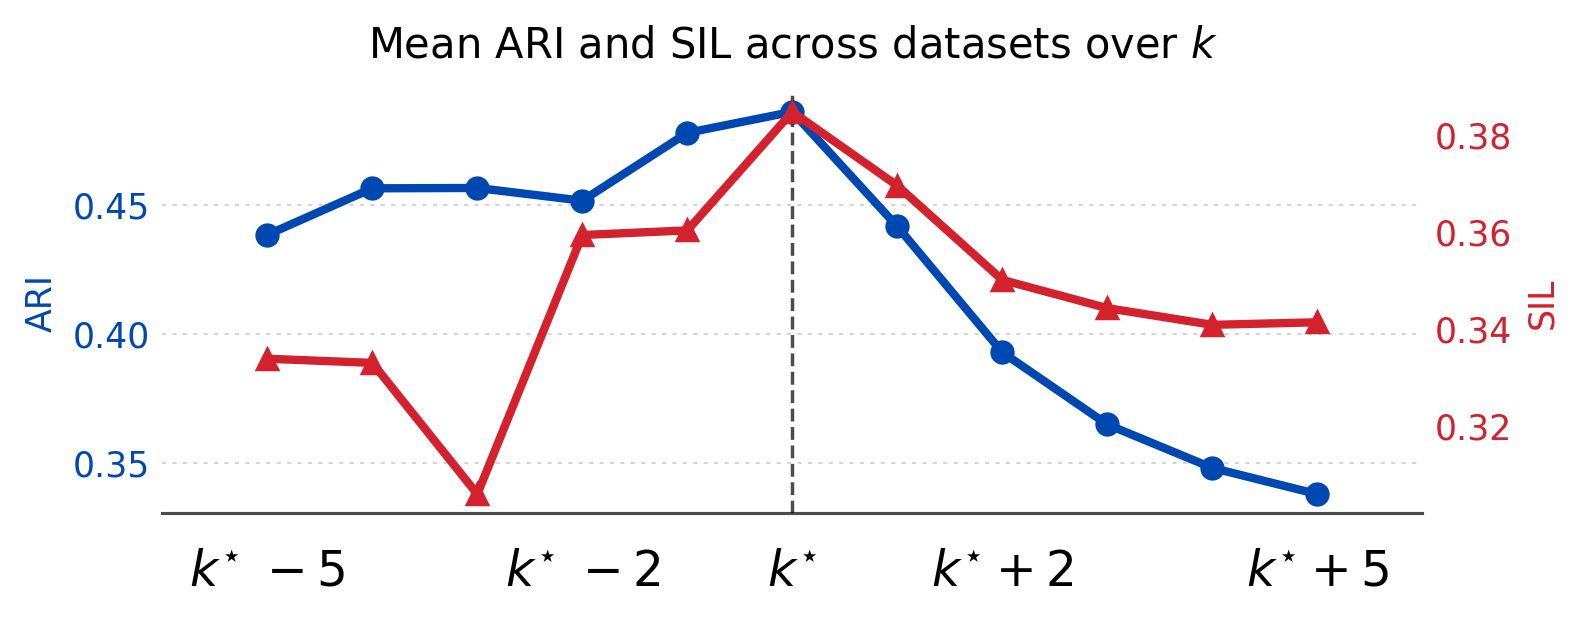

In [65]:
def plot_mean_ari_and_sil_over_k(across, outpath=None):
    deltas_full = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], dtype=int)
    g = (across.set_index("delta_k").reindex(deltas_full)).reset_index()

    x = g["delta_k"].to_numpy()
    y_ari = g["ARI_ds_mean_mean"].to_numpy()
    y_sil = g["sil_approx_mean_ds_mean_mean"].to_numpy()

    fig, ax1 = plt.subplots(figsize=(7, 3.4), dpi=250)

    ax1.plot(x, y_ari, marker="o", linewidth=2.4, color="#0048B1")
    ax1.set_ylabel("ARI", color="#0048B1")
    ax1.tick_params(axis="y", colors="#0048B1", length=0)

    ax2 = ax1.twinx()
    ax2.plot(x, y_sil, marker="^", linewidth=2.4, color="#D3212D")
    ax2.set_ylabel("SIL", color="#D3212D")
    ax2.tick_params(axis="y", colors="#D3212D", length=0)

    show_ticks = np.array([-5, -2, 0, 2, 5], dtype=int)
    tick_labels = []
    for d in show_ticks:
        if d == 0:
            tick_labels.append(r"$k^{\star}$")
        elif d > 0:
            tick_labels.append(rf"$k^{{\star}}+{d}$")
        else:
            tick_labels.append(rf"$k^{{\star}}\mathrm{{\;−{abs(d)}\;}}$")

    ax1.set_xticks(show_ticks)
    ax1.set_xticklabels(tick_labels, rotation=0)
    ax1.tick_params(axis="x", length=0, pad=10, labelsize=14)

    ax1.grid(False)
    ax2.grid(False)

    for sp in ("top", "left", "right"):
        ax1.spines[sp].set_visible(False)
    ax1.spines["bottom"].set_visible(True)
    ax1.spines["bottom"].set_linewidth(0.9)
    ax1.spines["bottom"].set_alpha(0.7)

    for sp in ("top", "bottom", "left", "right"):
        ax2.spines[sp].set_visible(False)

    ax1.margins(x=0.10)
    ax1.set_xlabel("")
    ax1.set_title(r"Mean ARI and SIL across datasets over $k$", pad=10)

    ax1.axvline(0, linestyle="--", linewidth=1.0, color="black", alpha=0.7)

    ax1.set_axisbelow(True)
    ax1.grid(
        True,
        axis="y",
        linestyle=(0, (2, 3)),
        linewidth=0.6,
        alpha=0.18,
        color="0.1"
    )

    plt.tight_layout(rect=[0.06, 0.14, 0.98, 0.90])

    if outpath is not None:
        plt.savefig(outpath, bbox_inches="tight")
    plt.show()

plot_mean_ari_and_sil_over_k(across)


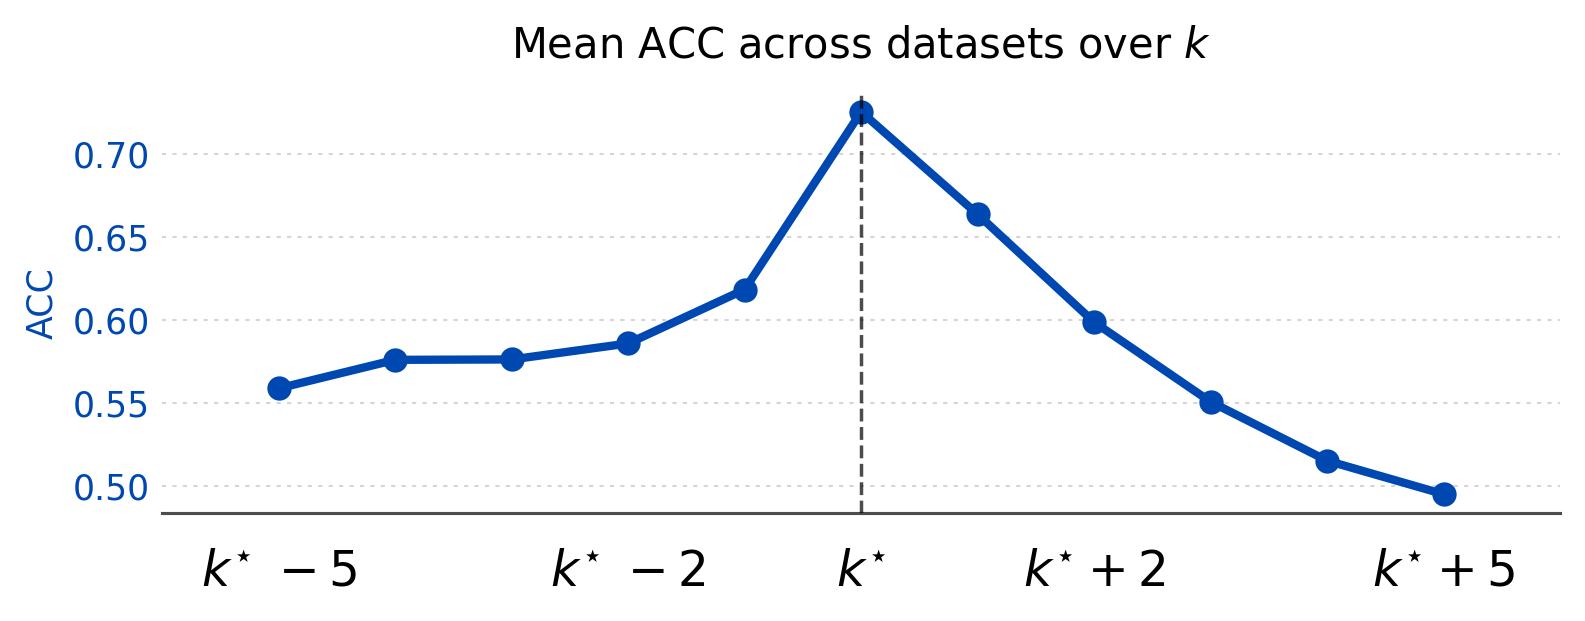

In [66]:
def run_k_misspec_ablation_acc(
    X_list, y_list, k_list, name_list,
    deltas,
    deltas_pos,
    repeats=10,
    base_seed=0,
    init="random",
    eta=0.2,
    max_iter=100,
    tol=1e-4,
    n_jobs=1,
):
    rows = []

    for ds_name, X, y, k_true in zip(name_list, X_list, y_list, k_list):
        X_arr = X.values if hasattr(X, "values") else np.asarray(X, dtype=float)
        y_arr = np.asarray(y)
        n_samples = X_arr.shape[0]
        k_true = int(k_true)

        candidates = make_k_candidates(
            k_true=k_true, n_samples=n_samples, deltas=deltas, deltas_pos=deltas_pos
        )

        for k_used, delta_k in candidates:
            for r in range(repeats):
                seed = int(base_seed + r)

                model = KSil(
                    n_clusters=int(k_used),
                    init=init,
                    max_iter=int(max_iter),
                    random_state=int(seed),
                    learning_rate=float(eta),
                    tol=float(tol),
                    n_init=1,
                    n_jobs=n_jobs,
                )

                labels = model.fit_predict(X_arr)
                acc = clustering_accuracy(y_arr, labels)

                rows.append({
                    "dataset": ds_name,
                    "k_true": k_true,
                    "k_used": int(k_used),
                    "delta_k": int(delta_k),
                    "repeat": int(r),
                    "ACC": float(acc),
                })

    return pd.DataFrame(rows)

df_k_acc = run_k_misspec_ablation_acc(
    X_list=X_list,
    y_list=y_list,
    k_list=k_list,
    name_list=name_list,
    deltas=deltas,
    deltas_pos=deltas_pos,
    repeats=repeats,
    base_seed=0,
    init="random",
    eta=eta_chosen,
    max_iter=100,
    tol=1e-4,
    n_jobs=n_jobs if "n_jobs" in globals() else 1,
)

_, across_acc = aggregate_delta_multi(df_k_acc, metrics=("ACC",))


def plot_mean_acc_over_k(across, outpath=None):
    deltas_full = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], dtype=int)
    g = (across.set_index("delta_k").reindex(deltas_full)).reset_index()

    x = g["delta_k"].to_numpy()
    y_acc = g["ACC_ds_mean_mean"].to_numpy()

    fig, ax = plt.subplots(figsize=(7, 3.4), dpi=250)

    ax.plot(x, y_acc, marker="o", linewidth=2.4, color="#0048B1")
    ax.set_ylabel("ACC", color="#0048B1")
    ax.tick_params(axis="y", colors="#0048B1", length=0)

    show_ticks = np.array([-5, -2, 0, 2, 5], dtype=int)
    tick_labels = []
    for d in show_ticks:
        if d == 0:
            tick_labels.append(r"$k^{\star}$")
        elif d > 0:
            tick_labels.append(rf"$k^{{\star}}+{d}$")
        else:
            tick_labels.append(rf"$k^{{\star}}\mathrm{{\;−{abs(d)}\;}}$")

    ax.set_xticks(show_ticks)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.tick_params(axis="x", length=0, pad=10, labelsize=14)

    ax.grid(False)

    for sp in ("top", "left", "right"):
        ax.spines[sp].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_linewidth(0.9)
    ax.spines["bottom"].set_alpha(0.7)

    ax.margins(x=0.10)
    ax.set_xlabel("")
    ax.set_title(r"Mean ACC across datasets over $k$", pad=10)

    ax.axvline(0, linestyle="--", linewidth=1.0, color="black", alpha=0.7)

    ax.set_axisbelow(True)
    ax.grid(
        True,
        axis="y",
        linestyle=(0, (2, 3)),
        linewidth=0.6,
        alpha=0.18,
        color="0.1"
    )

    plt.tight_layout(rect=[0.06, 0.14, 0.98, 0.90])

    if outpath is not None:
        plt.savefig(outpath, bbox_inches="tight")
    plt.show()

plot_mean_acc_over_k(across_acc)